In [1]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import sys
sys.path.append('../Codes/')
from models import *
from Epi_models import*
from functions import *
import networkx as nx
import matplotlib.animation as animation
import seaborn
import pickle
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as ticker
Text_files_path = '../../../../Dropbox/Research/Epidemiology_2020/Text_files/'
%autosave 60

Autosaving every 60 seconds


# Stochastic Model

In [2]:
N = 2000
graphs_names = np.array(['barabasi-albert','watts-strogatz'])
G1 = nx.barabasi_albert_graph(N, 2)
G2 = nx.watts_strogatz_graph(N, 4, 1)

#----Load data network of contacts----
N = 2000
graphs_names = np.array(['barabasi-albert','watts-strogatz'])
infile_k = open(Text_files_path+'Stochastic/Networks/barabasi-albert/k.pck','rb')
k = pickle.load(infile_k)
infile_k.close()
infile_p_k = open(Text_files_path+'Stochastic/Networks/barabasi-albert/p_k.pck','rb')
p_k = pickle.load(infile_p_k)
infile_p_k.close()
meanDegree = np.sum(k*p_k)
meanDegree2 = np.sum(k**2*p_k)
print(meanDegree, meanDegree2, np.max(k))

3.9960271618768215 47.23170201521739 265


## Ensemble

In [14]:
sample_sizes = [int((N/100)*1.875), int((N/100)*3.125), int((N/100)*5.0)]
print('Sample Sizes:',sample_sizes)
colors = ['b', 'g', 'r']
colors2 = ['purple', 'violet', 'brown']
N = 2000
print('N:', N)
gamma = 1/6
print('Gamma:', gamma)
sigma = 1/4
print('Sigma:', sigma)
graphs = [G1]
graphs_names = np.array(['barabasi-albert','watts-strogatz'])
sampling_protocol = np.array(['uniform', 'aposteriori'])
folders  = np.array(['../Figures/Control/Stochastic/Ensemble/Networks/', '../Figures/Stochastic/Networks/'])

#ps = np.array([0.0, 1.0])
ps = np.array([0.0, 1.0])
print('ps:',ps)
R0s = np.array([1.2, 2.0, 3.0, 4.5])
R0s2 = np.array([0.8, 1.2, 2.0, 3.0, 4.5]) # with network p=0

n_sims = np.array([10000, 10000, 10000, 10000, 10000])
#n_sims = np.array([8000, 8000, 8000, 6000, 6000])
print('n_sim:',n_sims)

Betas = np.array([R0s2*gamma,R0s*gamma])
print('Betas:', Betas)

R0_Ns = (R0s2*(meanDegree2-meanDegree))/(meanDegree*(meanDegree+R0s2))
R0_Es = np.sqrt(1-4*((sigma*gamma-sigma*Betas[1])/(sigma + gamma)**2))
R0_Es2 = np.sqrt(1-4*((sigma*gamma-sigma*Betas[0])/(sigma + gamma)**2))
R0_ENs = (R0_Es2*(meanDegree2-meanDegree))/(meanDegree*(meanDegree+R0_Es2))

print('R0s:', R0s)
print('R0_Es:',R0_Es)
print('R0_Ns:',R0_Ns)
print('R0_ENs:',R0_ENs)

lambdas = ((-sigma-gamma)/(2)) + (1/2)*np.sqrt((sigma-gamma)**2 + 4*sigma*Betas[1]) #exponential growth rates

ests = (1/(lambdas)).astype(int)
if(sigma==1/4):
    est_Ns = (1/((R0_ENs-1)*gamma)).astype(int)
    R0ss = R0_ENs
if(sigma==1000):
    est_Ns = (1/((R0_Ns-1)*gamma)).astype(int)
    R0ss = R0_Ns

Ts_Total = np.array([5*est_Ns,5*ests]) #for R0 = [1.2, 1.5, 3.0, 4.5] use [160, 35, 20] and half of it if when sigma=1000
print('Times:',Ts_Total)

#----Critical occupancy----
T_c = meanDegree/(meanDegree2-meanDegree)
u = np.linspace(0.00005,0.9,100000)

aposterioris = np.array([False, True])
protocols = np.array([0, 1])
print(aposterioris, protocols)

Sample Sizes: [37, 62, 100]
N: 2000
Gamma: 0.16666666666666666
Sigma: 0.25
ps: [0. 1.]
n_sim: [10000 10000 10000 10000 10000]
Betas: [array([0.13333333, 0.2       , 0.33333333, 0.5       , 0.75      ])
 array([0.2       , 0.33333333, 0.5       , 0.75      ])]
R0s: [1.2 2.  3.  4.5]
R0_Es: [1.09178753 1.4        1.70880075 2.0880613 ]
R0_Ns: [1.80477125 2.49875481 3.60894459 4.63963246 5.7307364 ]
R0_ENs: [1.9868922  2.3217778  2.80716357 3.24087804 3.7133128 ]
Times: [array([30, 20, 15, 10, 10]) array([260,  60,  30,  20])]
[False  True] [0 1]


In [15]:
%%time
for aposteriori, protocol in zip(aposterioris, protocols):
    print('Aposteriori:', aposteriori, ' Protocol: ', sampling_protocol[protocol])
    ##Run over values of p
    for p, Ts_total, betas in zip (ps, Ts_Total, Betas):
        ##Run over graphs
        for G, G_name in zip(graphs, graphs_names):
            ##Run over R0s
            for beta, T_total, n_sim in zip (betas, Ts_total, n_sims):
                print('p:',p)
                print('R0*:', np.sqrt(1-4*((sigma*(gamma-beta))/(sigma+gamma)**2)))
                slope = np.ones_like(k)
                if(aposteriori):
                    #T = 1-np.sum(p_k*(1/(1+(np.sqrt(1-4*((sigma*gamma-sigma*beta)/(sigma+gamma)**2)))/(k**2))))
                    if(sigma == 1000):
                        tau = 1/gamma
                    if(sigma == 1/4):
                        tau = 2*(sigma+gamma)**(-1)
                    T = 1-np.sum(p_k*(1/(1+((beta*tau)/(k*(k))))))
                    u_sol = u[np.array([np.sum(p_k*k*(1+(i-1)*T)**(k-1)) for i in u])>(np.sum(p_k*k)*u)][-1]
                    S = 1 - np.sum(p_k*(1-T+(T*u_sol))**k)**2
                    e_k = 1-(1-T+(T*u_sol))**(2*k)
                    slope = np.log10(e_k/S)
                    slope = slope - slope[0]
                    #print('slope:',slope)
                print('Succ nodes:')
                ### Generate new graph
                G = nx.barabasi_albert_graph(N, 2)
                ### run function
                %time run_network_ensemble(N=N, G=G, G_name=G_name, beta=beta, sigma=sigma, gamma=gamma, T_total=T_total,intervals=T_total+1, n_ensemble=n_sim, p = p, initE=0, initI=1, folder =Text_files_path+'Sampling/Networks/'+G_name+'/'+sampling_protocol[protocol]+'/k_normalization', stochastic = False, sampling = True, sample_sizes = sample_sizes, aposteriori= aposteriori, slope = slope)
                print('\n')

Aposteriori: False  Protocol:  uniform
p: 0.0
R0*: 0.8988882021697693
Succ nodes:
10000
CPU times: user 7min 48s, sys: 20.9 s, total: 8min 9s
Wall time: 8min 11s


p: 0.0
R0*: 1.0917875251164944
Succ nodes:
0
CPU times: user 7min 43s, sys: 20.2 s, total: 8min 4s
Wall time: 8min 4s


p: 0.0
R0*: 1.4000000000000001
Succ nodes:
17
CPU times: user 7min 51s, sys: 19.5 s, total: 8min 11s
Wall time: 8min 12s


p: 0.0
R0*: 1.7088007490635064
Succ nodes:
111
CPU times: user 7min 38s, sys: 19 s, total: 7min 57s
Wall time: 7min 57s


p: 0.0
R0*: 2.08806130178211
Succ nodes:
712
CPU times: user 8min, sys: 19.6 s, total: 8min 19s
Wall time: 8min 20s


p: 1.0
R0*: 1.0917875251164944
Succ nodes:
0
CPU times: user 31min 55s, sys: 24.6 s, total: 32min 20s
Wall time: 32min 22s


p: 1.0
R0*: 1.4000000000000001
Succ nodes:
4593
CPU times: user 56min 23s, sys: 32.6 s, total: 56min 55s
Wall time: 57min 3s


p: 1.0
R0*: 1.7088007490635064
Succ nodes:
5985
CPU times: user 35min 20s, sys: 26.5 s, total: 35min 

# Sampling results

In [15]:
data = np.loadtxt(Text_files_path+'Sampling/Networks/barabasi-albert/uniform/sampling_stats_R01.2_sigma1000.0_N2000_p0.0_m100_barabasi-albert.txt')
np.shape(data)


(230, 5)

In [6]:
N=2000
sample_sizes = [int((N/100)*1.875), int((N/100)*3.125), int((N/100)*5.0)]

Betas: [[0.75       0.5        0.33333333 0.2       ]
 [0.75       0.5        0.33333333 0.2       ]]
R0s: [4.5 3.  2.  1.2]
R0_Es: [1.0011656  1.00066622 1.00033317 1.00006664]
R0_Ns: [5.68484913 4.60248506 3.58005176 2.47875177]
R0_ENs: [2.15032008 2.14946231 2.14889013 2.1484322 ]
Times: [[  5  15  30 150]
 [  5   5  10  20]]
6 6 6
16 16 16
31 31 31
151 151 151


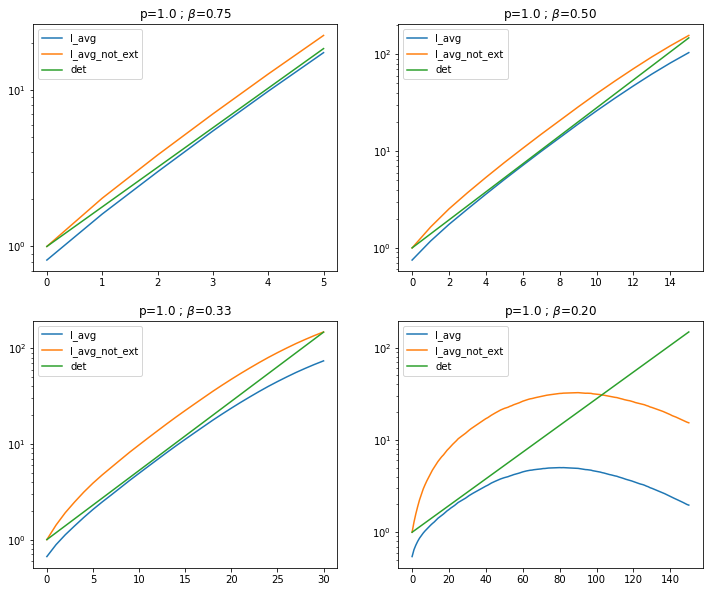

In [7]:
ps = [1.0]

sigma  = 1000
sample_sizes = [int((N/100)*1.875), int((N/100)*3.125), int((N/100)*5.0)]
R0s = np.array([4.5, 3.0, 2.0, 1.2])
R0s2 = np.array([4.5, 3.0, 2.0, 1.2, 0.8])
betas = R0s*gamma
betas2 = R0s2*gamma

Betas = np.array([R0s*gamma,R0s2*gamma])
print('Betas:', Betas)

R0_Ns = (R0s2*(meanDegree2-meanDegree))/(meanDegree*(meanDegree+R0s2))
R0_Es = np.sqrt(1-4*((sigma*gamma-sigma*Betas[0])/(sigma + gamma)**2))
R0_ENs = (R0_Es*(meanDegree2-meanDegree))/(meanDegree*(meanDegree+R0_Es))

print('R0s:', R0s)
print('R0_Es:',R0_Es)
print('R0_Ns:',R0_Ns)
print('R0_ENs:',R0_ENs)

lambdas = ((-sigma-gamma)/(2)) + (1/2)*np.sqrt((sigma-gamma)**2 + 4*sigma*Betas[1]) #exponential growth rates

ests = (1/(lambdas)).astype(int)
if(sigma==1/4):
    est_Ns = (1/((R0_ENs-1)*gamma)).astype(int)
if(sigma==1000):
    est_Ns = (1/((R0_Ns-1)*gamma)).astype(int)

Ts_Total = np.array([5*ests, 5*est_Ns]) #for R0 = [1.2, 1.5, 3.0, 4.5] use [160, 35, 20] and half of it if when sigma=1000
print('Times:',Ts_Total)

for p, Ts_total in zip(ps, Ts_Total):
    fig0, ax0 = plt.subplots(2,2,figsize=(12,10))
    k=0
    for beta, T_total in zip(betas, Ts_total):
        days = np.array(np.arange(T_total+1))
        I_data = np.loadtxt(Text_files_path+'Stochastic/Networks/barabasi-albert/ensemble_I_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(beta/gamma,sigma,N, p))
        I_avg = np.mean(I_data , axis = 0)
        I_data2 = [I_data[i,:] for i in np.arange(len(I_data[:,0])) if I_data[i,-1]!=0]
        I_avg_not_ext = np.mean(I_data2 , axis = 0)
        I_det = np.loadtxt(Text_files_path+'Deterministic/deterministic_analytic_R0%.1f_sigma%.1f_p%.1f_N%d.txt'%(beta/gamma,sigma,p,N))
        #for m, color, color2 in zip(sample_sizes, colors, colors2):
        print(len(days), len(I_avg_not_ext), len(I_det[2,:]))
        ax0[int(k/2), k%2].set_title(r'p=%.1f ; $\beta$=%.2f'%(p, beta))
        ax0[int(k/2), k%2].plot(days, I_avg, label= 'I_avg')
        ax0[int(k/2), k%2].plot(days, I_avg_not_ext, label= 'I_avg_not_ext')
        ax0[int(k/2), k%2].plot(days, I_det[2,:], label= 'det')
        ax0[int(k/2), k%2].set_yscale('log')
        ax0[int(k/2), k%2].legend()
        k+=1
    fig0.savefig('../Figures/Stochastic/Networks/barabasi-albert/Stochastic_effect.png')
        #fig, ax = plt.subplots(figsize=(12,8))
        #ax = plot_cum_prob_time(T_total, sample_sizes , beta/gamma, sigma, p, N, days , I_avg, I_det[2,:], colors, net_name = graphs_names[0], 
                                #folder=Text_files_path+'Sampling/Networks/'+graphs_names[0], external_ax = ax)
        #ax.legend(loc = 4, fontsize = 26)
        #fig.savefig('../Figures/Control/Stochastic/Sampling/Networks/'+graphs_names[0]+'/Prob_cum_R0%.1f_sigma%.1f_p%.1f_m%d.pdf'%(beta/gamma, sigma,p,m))

In [11]:
np.min((4,5))

4

Betas: [[0.2        0.33333333 0.5        0.75      ]
 [0.2        0.33333333 0.5        0.75      ]]
R0s: [1.2 2.  3.  4.5]
R0_Es: [1.00006664 1.00033317 1.00066622 1.0011656 ]
R0_Ns: [2.47875177 3.58005176 4.60248506 5.68484913]
R0_ENs: [2.1484322  2.14889013 2.14946231 2.15032008]
Times: [[ 20  10   5   5]
 [150  30  15   5]]


OSError: ../../../../Dropbox/Research/Epidemiology_2020/Text_files/Sampling/Networks/barabasi-albert/prob_cum_detection_time_R01.2_sigma1000.0_N2000_p0.0_m37_barabasi-albert.txt not found.

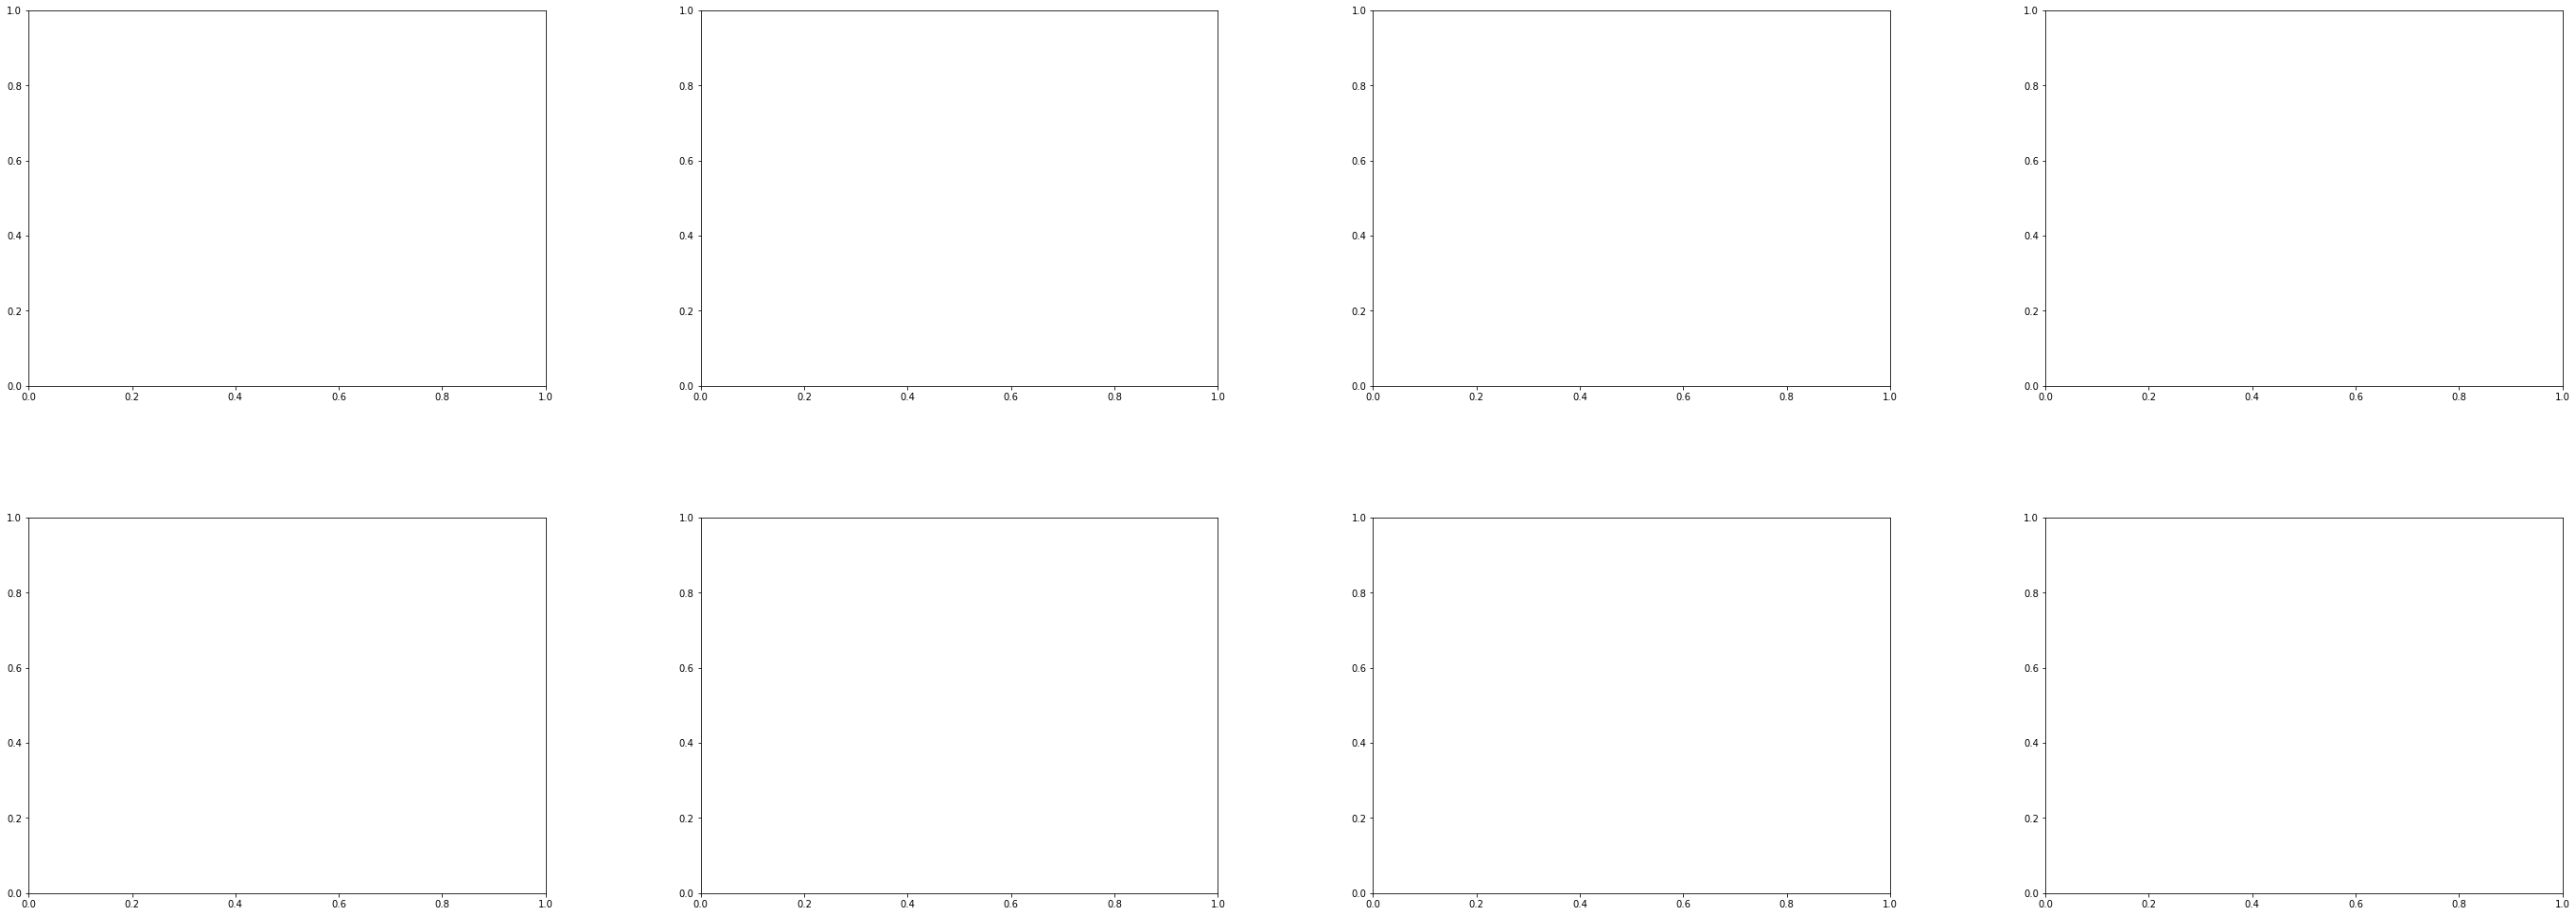

In [14]:
sigma = 1000
ps = np.array([0.0, 1.0])
ps2 = np.array([0.0, 1.0])
R0s = np.array([1.2, 2.0, 3.0, 4.5])
R0s2 = np.array([1.2, 2.0, 3.0, 4.5])
betas = R0s*gamma
betas2 = R0s2*gamma
Ts_total = np.array([520, 120,  60,  40])
colors_m = ['darkgreen', 'darkblue', 'darkred']
colors = ['green', 'blue', 'red']
fig, ax = plt.subplots(len(ps2), len(betas2), figsize =(12*len(betas2), 8*len(ps2)), gridspec_kw={'top':0.93, 'bottom': 0.12, 'hspace':0.35, 'wspace':0.3})
i_p = 0

Betas = np.array([R0s2*gamma,R0s*gamma])
print('Betas:', Betas)
R0_Ns = (R0s2*(meanDegree2-meanDegree))/(meanDegree*(meanDegree+R0s2))
R0_Es = np.sqrt(1-4*((sigma*gamma-sigma*Betas[0])/(sigma + gamma)**2))
R0_ENs = (R0_Es*(meanDegree2-meanDegree))/(meanDegree*(meanDegree+R0_Es))

print('R0s:', R0s2)
print('R0_Es:',R0_Es)
print('R0_Ns:',R0_Ns)
print('R0_ENs:',R0_ENs)

lambdas = ((-sigma-gamma)/(2)) + (1/2)*np.sqrt((sigma-gamma)**2 + 4*sigma*Betas[1]) #exponential growth rates

ests = (1/(lambdas)).astype(int)
if(sigma==1/4):
    est_Ns = (1/((R0_ENs-1)*gamma)).astype(int)
if(sigma==1000):
    est_Ns = (1/((R0_Ns-1)*gamma)).astype(int)

Ts_Total = np.array([5*est_Ns,5*ests]) #for R0 = [1.2, 1.5, 3.0, 4.5] use [160, 35, 20] and half of it if when sigma=1000
print('Times:',Ts_Total)

for p, Ts_total in zip(ps, Ts_Total):
    i_b = 0
    for beta, T_total in zip(betas, Ts_total):
        days = np.array(np.arange(T_total+1))
        I_data = np.loadtxt(Text_files_path+'Stochastic/Networks/barabasi-albert/ensemble_I_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(beta/gamma,sigma,N,p))
        #I_data_ap = np.loadtxt('../Text_files/Stochastic/Networks/barabasi-albert/aposteriori/ensemble_I_R0%.1f_sigma%.1f_N8000_p%.1f_barabasi-albert.txt'%(beta/gamma,sigma,p))
        I_avg = np.mean(I_data , axis = 0)
        I_data2 = [I_data[i,:] for i in np.arange(len(I_data[:,0])) if I_data[i,-1]!=0]
        I_avg_not_ext = np.mean(I_data2 , axis = 0)
        I_det = np.loadtxt(Text_files_path+'Deterministic/deterministic_R0%.1f_sigma%.1f_p%.1f_N%d.txt'%(beta/gamma, sigma, p, N))
        for m, color, color_m in zip(sample_sizes, colors, colors_m):
            data_prob = np.loadtxt(Text_files_path+'Sampling/Networks/barabasi-albert/prob_cum_detection_time_R0%.1f_sigma%.1f_N%d_p%.1f_m%d_barabasi-albert.txt'%(beta/gamma,sigma,N,p,m))
            if((np.isin(p,ps2))&(np.isin(beta,betas2))):
                ax[i_p, i_b].plot(days, data_prob[0,:], color = color_m, linewidth = 4, label = 'm=%d'%m)
                ax.plot(days,np.cumsum(data_prob[1,:]), color = 'k', linewidth = 4, label = 'm=%d, deterministic'%m)
                ax[i_p, i_b].hlines(0,0,I_det[0,:][-1], linestyle = 'dashed', linewidth = 3)
            
            data_sampling = np.loadtxt(Text_files_path+'Sampling/Networks/barabasi-albert/uniform/sampling_stats_R0%.1f_sigma%.1f_N%d_p%.1f_m%d_barabasi-albert.txt'%(beta/gamma,sigma,N,p,m))
            data_sampling2 = np.loadtxt(Text_files_path+'Sampling/Networks/barabasi-albert/uniform/sampling_stats_R0%.1f_sigma%.1f_N%d_p%.1f_m%d_barabasi-albert.txt'%(beta/gamma,sigma,N,p,m))

            data_sampling = data_sampling[:,0][data_sampling[:,4]==0]
            data_sampling2 = data_sampling2[:,0][data_sampling2[:,4]==0]
            
            #ax.hist(time_detec, bins = range(T_total+1), density=True, alpha = 0.8, color = color, cumulative=True, align = 'left', label = 'uniform')
            data_uniform = np.histogram(data_sampling, bins = np.arange(T_total+1), density=True)
            data_aposteriori = np.histogram(data_sampling2, bins = np.arange(T_total+1), density=True)
            if((np.isin(p,ps2))&(np.isin(beta,betas2))):
                #print(len(data_sampling),len(data_sampling2))
                ax[i_p, i_b].plot(np.arange(T_total), data_uniform[0],'-o', color = color, ms = 8, linewidth = 1)
                ax[i_p, i_b].plot(np.arange(T_total), data_aposteriori[0],'-^', color = color, ms = 8, linewidth = 1)
                ## Plot setup
                ax[i_p, i_b].set_xlabel('Time [days]', fontsize = 30)
                ax[i_p, i_b].set_ylabel('Prob. detection', fontsize = 30)
                ax[i_p, i_b].tick_params(labelsize = 30)
                #ax[i_p, i_b].set_xticks(I_det[0,:][::int(T_total/5)])
                ax[i_p, i_b].set_xlim(0,T_total)
                #ax[i_p, i_b].legend(loc = 1, fontsize = 26)
                ## Upper axis
                ax2 = ax[i_p, i_b].twiny()
                #ax2.set_xticks(ax[i_p, i_b].get_xticks())
                ax2.set_xlim(ax[i_p, i_b].get_xlim())
                #print(I_det[0,:], ax.get_xticks(), I_avg_not_ext)
                #ax2.set_xticklabels(I_avg_not_ext[np.isin(I_det[0,:],ax[i_p, i_b].get_xticks())].astype(int))
                ax2.set_xlabel('Individuals', fontsize = 30)
                ax2.tick_params(labelsize = 20)
                #fig.savefig('../Figures/Control/Stochastic/Sampling/Networks/'+graphs_names[0]+'/Prob_R0%.1f_sigma%.1f_p%.1f_m%d.pdf'%(beta/gamma, sigma,p,m))
        if((np.isin(p,ps2))&(np.isin(beta,betas2))):
            i_b +=1
    if((np.isin(p,ps2))&(np.isin(beta,betas2))):
        i_p+=1

OSError: ../../../../Dropbox/Research/Epidemiology_2020/Text_files/Deterministic/deterministic_R01.2_sigma0.2.txt not found.

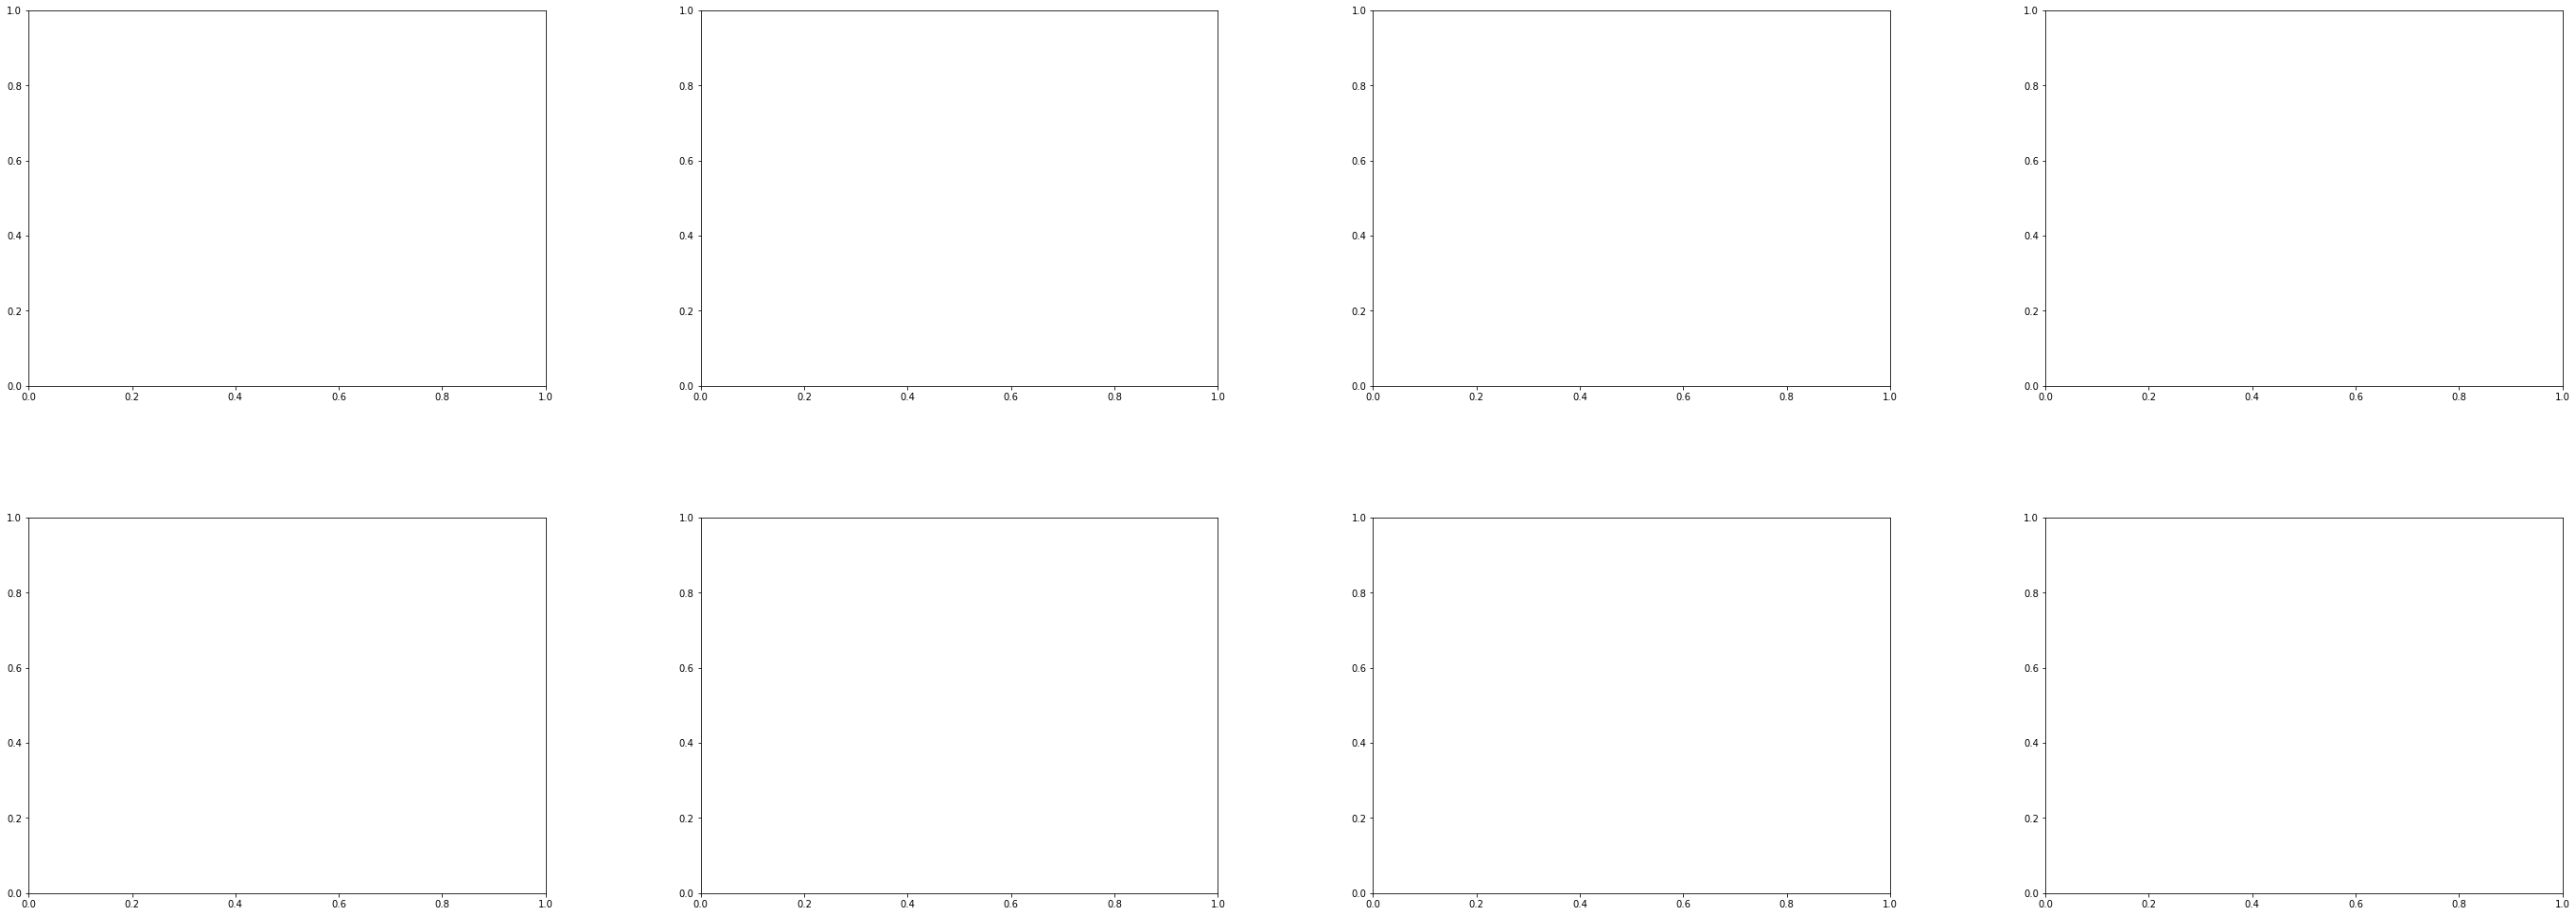

In [21]:
colors_m = ['darkgreen', 'darkblue', 'darkred']
colors = ['green', 'blue', 'red']
fig, ax = plt.subplots(len(ps2), len(betas2), figsize =(12*len(betas2), 8*len(ps2)), gridspec_kw={'top':0.93, 'bottom': 0.12, 'hspace':0.35, 'wspace':0.3})

file = open(Text_files_path+'Sampling/Networks/barabasi-albert/uniform/uniform_sampling_N%d.txt'%N, 'w')
file2 = open(Text_files_path+'Sampling/Networks/barabasi-albert/uniform/aposteriori_sampling_N%d.txt'%N, 'w')
i_p = 0
for p in ps:
    i_b = 0
    for beta, T_total in zip(betas, Ts_total):
        time_x = np.linspace(0,T_total-1,500)
        days = np.array(range(T_total+1))
        I_data = np.loadtxt(Text_files_path+'Stochastic/Networks/barabasi-albert/ensemble_I_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(beta/gamma,sigma,N,p))
        #I_data_ap = np.loadtxt('../Text_files/Control/Stochastic/Networks/barabasi-albert/aposteriori/ensemble_I_R0%.1f_sigma%.1f_N8000_p%.1f_barabasi-albert.txt'%(beta/gamma,sigma,p))
        I_avg = np.mean(I_data , axis = 0)
        I_data2 = [I_data[i,:] for i in range(len(I_data[:,0])) if I_data[i,-1]!=0]
        I_avg_not_ext = np.mean(I_data2 , axis = 0)
        I_det = np.loadtxt(Text_files_path+'Deterministic/deterministic_R0%.1f_sigma%.1f.txt'%(beta/gamma,sigma))
        for m, color, color_m in zip(sample_sizes, colors, colors_m):
            data_prob = np.loadtxt(Text_files_path+'Sampling/Networks/barabasi-albert/prob_cum_detection_time_R0%.1f_sigma%.1f_N%d_p%.1f_m%d_barabasi-albert.txt'%(beta/gamma,sigma,N,p,m))
            if((np.isin(p,ps2))&(np.isin(beta,betas2))):
                ax[i_p, i_b].plot(days, np.cumsum(data_prob[0,:]), color = color_m, linewidth = 4, label = 'm=%d'%m)
                #ax.plot(days,np.cumsum(data_prob[1,:]), color = 'k', linewidth = 4, label = 'm=%d, deterministic'%m)
                ax[i_p, i_b].hlines(1,0,I_det[0,:][-1], linestyle = 'dashed', linewidth = 3)
                ax[i_p, i_b].hlines(.9,0,I_det[0,:][-1], linestyle = 'dashed', linewidth = 3)
            
            data_sampling = np.loadtxt(Text_files_path+'Sampling/Networks/barabasi-albert/uniform/sampling_stats_R0%.1f_sigma%.1f_N%d_p%.1f_m%d_barabasi-albert.txt'%(beta/gamma,sigma,N,p,m))
            data_sampling2 = np.loadtxt(Text_files_path+'Sampling/Networks/barabasi-albert/aposteriori/sampling_stats_R0%.1f_sigma%.1f_N%d_p%.1f_m%d_barabasi-albert.txt'%(beta/gamma,sigma,N,p,m))
            
            data_sampling = data_sampling[:,0][data_sampling[:,4]==0]
            data_sampling2 = data_sampling2[:,0][data_sampling2[:,4]==0]
            
            #ax.hist(time_detec, bins = range(T_total+1), density=True, alpha = 0.8, color = color, cumulative=True, align = 'left', label = 'uniform')
            data_uniform = np.histogram(data_sampling, bins = range(T_total+1), density=True)
            data_aposteriori = np.histogram(data_sampling2, bins = range(T_total+1), density=True)
            
            #interpolations
            f = interp1d(range(T_total), np.cumsum(data_uniform[0]), 'cubic')
            f2 = interp1d(range(T_total), np.cumsum(data_aposteriori[0]), 'cubic')
            
            g = interp1d(range(T_total), I_avg_not_ext[:-1], 'cubic')
            
            if((np.isin(p,ps2))&(np.isin(beta,betas2))):
                ax[i_p, i_b].plot(range(T_total), np.cumsum(data_uniform[0]),'-o', color = color, ms = 8, linewidth = 1)
                ax[i_p, i_b].plot(range(T_total), np.cumsum(data_aposteriori[0]),'-^', color = color, ms = 8, linewidth = 1)
                ## Plot setup
                ax[i_p, i_b].set_xlabel('Time [days]', fontsize = 30)
                ax[i_p, i_b].set_ylabel('Cumulative Probability', fontsize = 30)
                ax[i_p, i_b].tick_params(labelsize = 30)
                ax[i_p, i_b].set_ylim(0,1.1)
                ax[i_p, i_b].set_xticks(I_det[0,:][::int(T_total/5)])
                ax[i_p, i_b].set_xlim(0,T_total)
                ax[i_p, i_b].legend(loc = 4, fontsize = 26)
                ## Upper axis
                ax2 = ax[i_p, i_b].twiny()
                ax2.set_xticks(ax[i_p, i_b].get_xticks())
                ax2.set_xlim(ax[i_p, i_b].get_xlim())
                #print(I_det[0,:], ax.get_xticks(), I_avg_not_ext)
                ax2.set_xticklabels(I_avg_not_ext[np.isin(I_det[0,:],ax[i_p, i_b].get_xticks())].astype(int))
                ax2.set_xlabel('Individuals', fontsize = 30)
                ax2.tick_params(labelsize = 20)
                #fig.savefig('../Figures/Control/Stochastic/Sampling/Networks/'+graphs_names[0]+'/Prob_R0%.1f_sigma%.1f_p%.1f_m%d.pdf'%(beta/gamma, sigma,p,m))
            #save data
            R0s = np.sqrt(1-4*((sigma*(gamma-beta))/(sigma+gamma)**2))
            time90 = time_x[np.where(f(time_x)<=0.9)][-1]
            #ind90 = I_avg_not_ext[int(round(time90))]
            ind90 = g(time90)
            time902 = time_x[np.where(f2(time_x)<=0.9)][-1]
            #ind902 = I_avg_not_ext[int(round(time902))]
            ind902 = g(time902)
            np.savetxt(file, np.array([p, R0s, m, time90, ind90]), newline = ' ')
            np.savetxt(file2, np.array([p, R0s, m, time902, ind902]), newline = ' ')
            file.write("\n")
            file2.write("\n")
        if((np.isin(p,ps2))&(np.isin(beta,betas2))):
            i_b +=1
    if((np.isin(p,ps2))&(np.isin(beta,betas2))):
        i_p+=1
file.close()
file2.close()


In [1]:
ps1 = np.array([0.0])
R0s1 = np.array([1.5])
Ts_total = np.array([150])
betas1 = R0s1*gamma
colors_m = ['darkgreen', 'darkblue', 'darkred']
colors = ['green', 'blue', 'red']
from matplotlib.lines import Line2D
lines_symbols = [Line2D([0], [0], color='k', linewidth=4, linestyle='-',marker='o', ms = 8), Line2D([0], [0], color='k', linewidth=4, linestyle='-',marker='^', ms = 8), 
                Line2D([0], [0], color='green', linewidth=4, linestyle='-'), Line2D([0], [0], color='blue', linewidth=4, linestyle='-'), 
                Line2D([0], [0], color='red', linewidth=4, linestyle='-')]
labels_symbols = ['Uniform', 'Degree-based', 'm=2%', 'm=3%', 'm=5%']

for p in ps1:
    print('p:',p)
    for beta, T_total in zip(betas1, Ts_total):
        fig, ax = plt.subplots(figsize =(12, 8), gridspec_kw={'top':0.9, 'bottom': 0.12, 'hspace':0.35, 'wspace':0.3, 'left':0.15, 'right': 0.98})
        days = np.array(range(T_total+1))
        I_data = np.loadtxt('../Text_files/Stochastic/Networks/barabasi-albert/ensemble_I_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(beta/gamma,sigma,N,p))
        #I_data_ap = np.loadtxt('../Text_files/Control/Stochastic/Networks/barabasi-albert/aposteriori/ensemble_I_R0%.1f_sigma%.1f_N8000_p%.1f_barabasi-albert.txt'%(beta/gamma,sigma,p))
        I_avg = np.mean(I_data , axis = 0)
        I_data2 = [I_data[i,:] for i in range(len(I_data[:,0])) if I_data[i,-1]!=0]
        I_avg_not_ext = np.mean(I_data2 , axis = 0)
        I_det = np.loadtxt('../Text_files/Deterministic/deterministic_R0%.1f_sigma%.1f.txt'%(beta/gamma,sigma))
        for m, color, color_m in zip(sample_sizes, colors_m, colors_m):
            data_prob = np.loadtxt('../Text_files/Sampling/Networks/barabasi-albert/prob_cum_detection_time_R0%.1f_sigma%.1f_N%d_p%.1f_m%d_barabasi-albert.txt'%(beta/gamma,sigma,N,p,m))
            #ax.plot(I_det[0,:], np.cumsum(data_prob[0,:]), color = color_m, linewidth = 4, label = 'm=%.1f %%'%((m/N)*100))
            ax.hlines(1,0,I_det[0,:][-1], linestyle = 'dashed', linewidth = 3)
            ax.hlines(.9,0,I_det[0,:][-1], linestyle = 'dashed', linewidth = 3, alpha=0.5)
            
            data_sampling = np.loadtxt('../Text_files/Sampling/Networks/barabasi-albert/uniform/sampling_stats_R0%.1f_sigma%.1f_N%d_p%.1f_m%d_barabasi-albert.txt'%(beta/gamma,sigma,N,p,m))
            data_sampling2 = np.loadtxt('../Text_files/Sampling/Networks/barabasi-albert/aposteriori/sampling_stats_R0%.1f_sigma%.1f_N%d_p%.1f_m%d_barabasi-albert.txt'%(beta/gamma,sigma,N,p,m))
        
            #ax.hist(time_detec, bins = range(T_total+1), density=True, alpha = 0.8, color = color, cumulative=True, align = 'left', label = 'uniform')
            data_uniform = np.histogram(data_sampling[:,0][data_sampling[:,4]==0], bins = range(T_total+1), density=True)
            data_aposteriori = np.histogram(data_sampling2[:,0][data_sampling2[:,4]==0], bins = range(T_total+1), density=True)

            ax.plot(range(T_total), np.cumsum(data_uniform[0]),'-o', color = color, ms = 8, linewidth = 1)
            ax.plot(range(T_total), np.cumsum(data_aposteriori[0]),'-^', color = color, ms = 8, linewidth = 1)
            ## Plot setup
            ax.set_xlabel('Time [days]', fontsize = 30)
            ax.set_ylabel('Cumulative Probability', fontsize = 30)
            ax.tick_params(labelsize = 30)
            ax.set_ylim(0,1.1)
            ax.set_xticks(I_det[0,:][::int(T_total/10)])
            ax.set_xlim(0,45)
            handles, labels = ax.get_legend_handles_labels()
            ax.legend( np.concatenate((lines_symbols,handles)), np.concatenate((labels_symbols,labels)) , loc = 4, fontsize = 26)
            ## Upper axis
            ax2 = ax.twiny()
            ax2.set_xticks(ax.get_xticks())
            ax2.set_xlim(ax.get_xlim())
            #print(I_det[0,:], ax.get_xticks(), I_avg_not_ext)
            ax2.set_xticklabels(I_avg_not_ext[np.isin(I_det[0,:],ax.get_xticks())].astype(int))
            ax2.set_xlabel('Individuals', fontsize = 30)
            ax2.tick_params(labelsize = 20)
        #fig.savefig('../Figures/Sampling/Networks/'+graphs_names[0]+'/Prob_R0%.1f_sigma%.1f_N%d_p%.1f.pdf'%(beta/gamma, sigma,N,p))


NameError: name 'np' is not defined

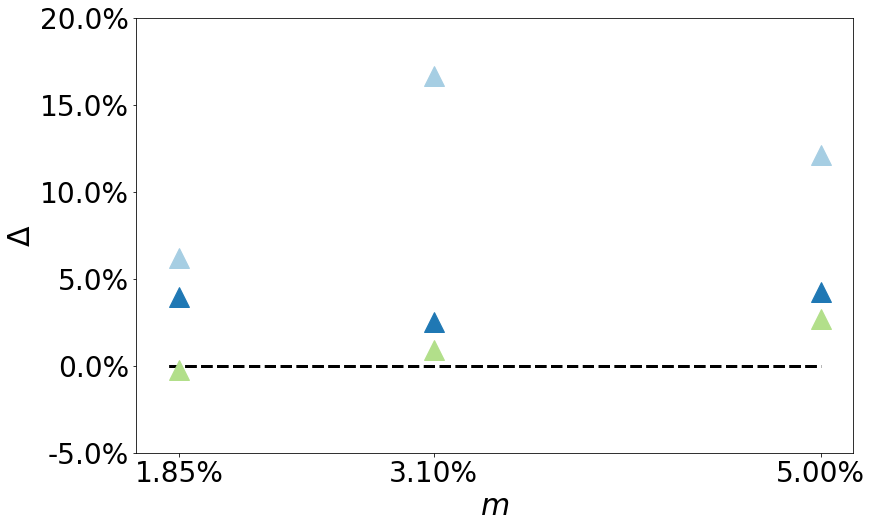

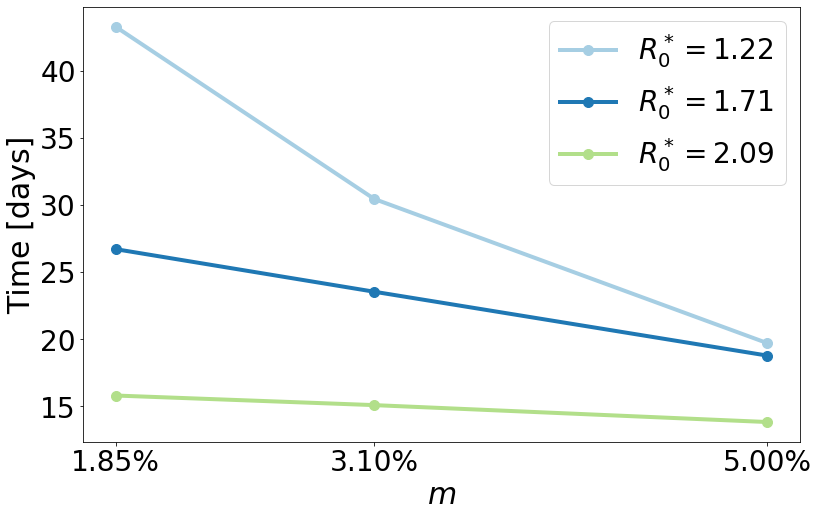

In [120]:
R0ss = np.sqrt(1-4*((sigma*(gamma-betas))/(sigma+gamma)**2))
colors_R = plt.cm.Paired(range(7))
stats_uniform = np.loadtxt('../Text_files/Sampling/Networks/barabasi-albert/uniform/uniform_sampling_N%d.txt'%N)
stats_aposteriori = np.loadtxt('../Text_files/Sampling/Networks/barabasi-albert/aposteriori/aposteriori_sampling_N%d.txt'%N)
fig, ax = plt.subplots(figsize = (12, 8), gridspec_kw={'wspace':0.1, 'left':0.15, 'right': 0.98})
fig2, ax2 = plt.subplots(figsize = (12, 8), gridspec_kw={'wspace':0.1, 'left':0.15, 'right': 0.98})


left, bottom, width, height = [0.68, 0.6, 0.27, 0.27]
#ax2 = fig.add_axes([left, bottom, width, height])

i = 0
ps = [0.0]
for p in ps:
    for R0s, color in zip(R0ss, colors_R):
        #ax.set_title('$p =$%.1f'%p, fontsize = 30)
        #ax[int(i/2), int(i%2)].plot(sample_sizes,stats_uniform[np.where((stats_uniform[:,0]==p) & (stats_uniform[:,1]==R0s))][:,3], color = color, linestyle = '--', label = '$R_0^*=$%.3f'%R0s, linewidth = 4)
        ax.hlines(0, N*0.018 ,N*0.05, linestyle = 'dashed', linewidth = 3)
        stats_aposteriori_i = stats_aposteriori[np.where((stats_aposteriori[:,0]==p) & (stats_aposteriori[:,1]==R0s))][:,3]
        stats_uniform_i = stats_uniform[np.where((stats_uniform[:,0]==p) & (stats_uniform[:,1]==R0s))][:,3]
        ax.plot(sample_sizes,(stats_uniform_i-stats_aposteriori_i)/stats_uniform_i, '^', ms = 20, color = color, linewidth = 4, label = '$R_0^*=$%.2f'%R0s)
        ax.set_ylabel('$\Delta$', fontsize = 30)
        ax.set_xlabel('$m$', fontsize = 30)
        #ax.legend(fontsize = 28, loc = 4)
        ax.set_xticks(sample_sizes)
        ax.set_ylim(-0.05, 0.20)

            
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=N))
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
        ax.tick_params(labelsize = 28)
        
        
        ax2.plot(sample_sizes, stats_uniform_i, 'o-', ms = 10, color = color, linewidth = 4, label = '$R_0^*=$%.2f'%R0s)
        ax2.set_ylabel('Time [days]', fontsize = 30)
        ax2.set_xlabel('$m$', fontsize = 30)
        ax2.legend(fontsize = 28, loc = 1)
        ax2.set_xticks(sample_sizes)
        #ax2.set_ylim(-0.20, 0.40)
        ax2.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=N))
        ax2.tick_params(labelsize = 28)
        ax2.set_xticks(sample_sizes)
        
    i+=1

    #fig.savefig('../Figures/Sampling/Networks/barabasi-albert/times_detection_delta_N%d_p%.1f.png'%(N,p))
    #fig2.savefig('../Figures/Sampling/Networks/barabasi-albert/times_detection_N%d_p%.1f.png'%(N,p))



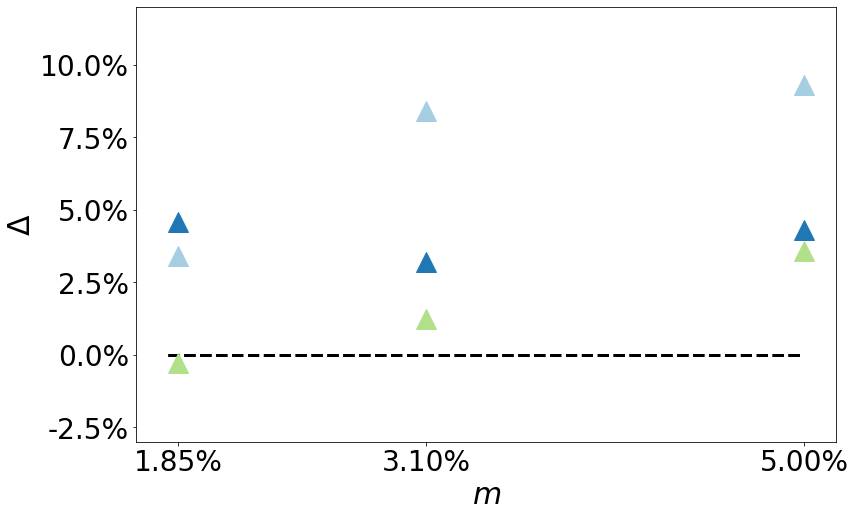

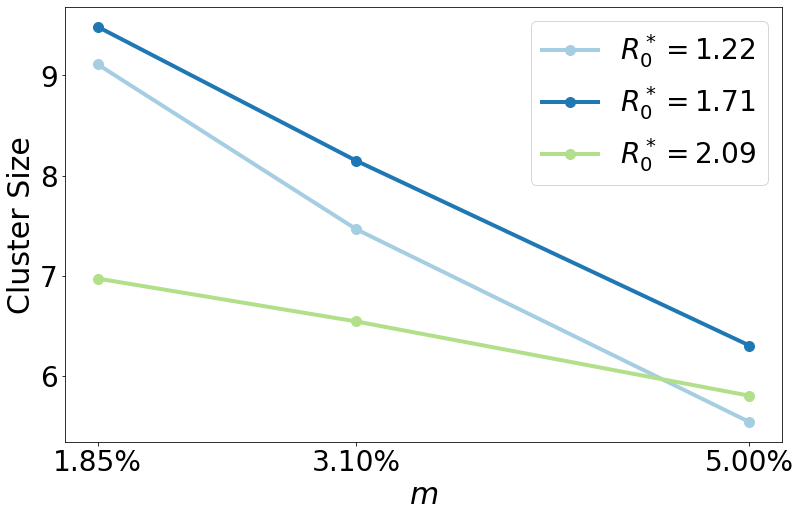

In [119]:
R0ss = np.sqrt(1-4*((sigma*(gamma-betas))/(sigma+gamma)**2))
colors_R = plt.cm.Paired(range(7))
stats_uniform = np.loadtxt('../Text_files/Sampling/Networks/barabasi-albert/uniform/uniform_sampling_N%d.txt'%N)
stats_aposteriori = np.loadtxt('../Text_files/Sampling/Networks/barabasi-albert/aposteriori/aposteriori_sampling_N%d.txt'%N)
fig, ax = plt.subplots(figsize = (12, 8), gridspec_kw={'wspace':0.1, 'left':0.17, 'right': 0.98})
fig2, ax2 = plt.subplots(figsize = (12, 8), gridspec_kw={'wspace':0.1, 'left':0.15, 'right': 0.98})


left, bottom, width, height = [0.68, 0.6, 0.27, 0.27]
#ax2 = fig.add_axes([left, bottom, width, height])

i = 0
ps = [0.0]
for p in ps:
    for R0s, color in zip(R0ss, colors_R):
        #ax.set_title('$p =$%.1f'%p, fontsize = 30)
        #ax[int(i/2), int(i%2)].plot(sample_sizes,stats_uniform[np.where((stats_uniform[:,0]==p) & (stats_uniform[:,1]==R0s))][:,3], color = color, linestyle = '--', label = '$R_0^*=$%.3f'%R0s, linewidth = 4)
        ax.hlines(0, N*0.018 ,N*0.05, linestyle = 'dashed', linewidth = 3)
        stats_aposteriori_i = stats_aposteriori[np.where((stats_aposteriori[:,0]==p) & (stats_aposteriori[:,1]==R0s))][:,4]
        stats_uniform_i = stats_uniform[np.where((stats_uniform[:,0]==p) & (stats_uniform[:,1]==R0s))][:,4]
        ax.plot(sample_sizes,(stats_uniform_i-stats_aposteriori_i)/stats_uniform_i, '^', ms = 20, color = color, linewidth = 4, label = '$R_0^*=$%.2f'%R0s)
        ax.set_ylabel('$\Delta$', fontsize = 30)
        ax.set_xlabel('$m$', fontsize = 30)
        #ax.legend(fontsize = 28)
        ax.set_xticks(sample_sizes)
        ax.set_ylim(-0.03, 0.12)   
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=N))
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
        ax.tick_params(labelsize = 28)
        
        
        ax2.plot(sample_sizes, stats_uniform_i, 'o-', ms = 10, color = color, linewidth = 4, label = '$R_0^*=$%.2f'%R0s)
        ax2.set_ylabel('Cluster Size', fontsize = 30)
        ax2.set_xlabel('$m$', fontsize = 30)
        ax2.legend(fontsize = 28)
        ax2.set_xticks(sample_sizes)
        ax2.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=N))
        ax2.tick_params(labelsize = 28)
        ax2.set_xticks(sample_sizes)
        
    i+=1

    #fig.savefig('../Figures/Sampling/Networks/barabasi-albert/cluster_size_delta_N%d_p%.1f.png'%(N,p))
    #fig2.savefig('../Figures/Sampling/Networks/barabasi-albert/cluster_size_N%d_p%.1f.png'%(N,p))




In [ ]:
ps = [1.0, 0.0]
R0ss = np.sqrt(1-4*((sigma*(gamma-betas))/(sigma+gamma)**2))
colors_R = plt.cm.Paired(range(7))
stats_uniform = np.loadtxt('../Text_files/Sampling/Networks/barabasi-albert/uniform/uniform_sampling_N%d.txt'%N)
stats_aposteriori = np.loadtxt('../Text_files/Sampling/Networks/barabasi-albert/aposteriori/aposteriori_sampling_N%d.txt'%N)
fig, ax = plt.subplots(2, 2, figsize = (24, 16), gridspec_kw={'wspace':0.1, 'right': 0.8})
i = 0
for p in ps:
    for R0s, color in zip(R0ss, colors_R):
        ax[int(i/2), int(i%2)].set_title('$p =$%.1f'%p, fontsize = 30)
        #ax[int(i/2), int(i%2)].plot(sample_sizes,stats_uniform[np.where((stats_uniform[:,0]==p) & (stats_uniform[:,1]==R0s))][:,3], color = color, linestyle = '--', label = '$R_0^*=$%.3f'%R0s, linewidth = 4)
        ax[int(i/2), int(i%2)].hlines(0, N*0.018 ,N*0.05, linestyle = 'dashed', linewidth = 3)
        stats_aposteriori_i = stats_aposteriori[np.where((stats_aposteriori[:,0]==p) & (stats_aposteriori[:,1]==R0s))][:,3]
        stats_uniform_i = stats_uniform[np.where((stats_uniform[:,0]==p) & (stats_uniform[:,1]==R0s))][:,3]
        ax[int(i/2), int(i%2)].plot(sample_sizes,(stats_uniform_i-stats_aposteriori_i)/stats_uniform_i, '^', ms = 20, color = color, linewidth = 4, label = '$R_0^*=$%.2f'%R0s)
        if(int(i%2)==0):
            ax[int(i/2), int(i%2)].set_ylabel('Time [days]', fontsize = 30)
        if(int(i%2)==1):
            ax[int(i/2), int(i%2)].legend(fontsize = 28, bbox_to_anchor=(1,0.75))
            ax[int(i/2), int(i%2)].set_yticks([])
        if(int(i/2)==0):
            ax[int(i/2), int(i%2)].set_xticks([])
            ax[int(i/2), int(i%2)].set_ylim(-0.30, 0.30)
        if(int(i/2)==1):
            ax[int(i/2), int(i%2)].set_xticks(sample_sizes)
            ax[int(i/2), int(i%2)].set_ylim(-0.30, 0.30)
            
        ax[int(i/2), int(i%2)].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=N))
        ax[int(i/2), int(i%2)].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
        ax[int(i/2), int(i%2)].tick_params(labelsize = 28)
        
    i+=1

fig.savefig('../Figures/Sampling/Networks/barabasi-albert/times_detection_N%d.png'%N)


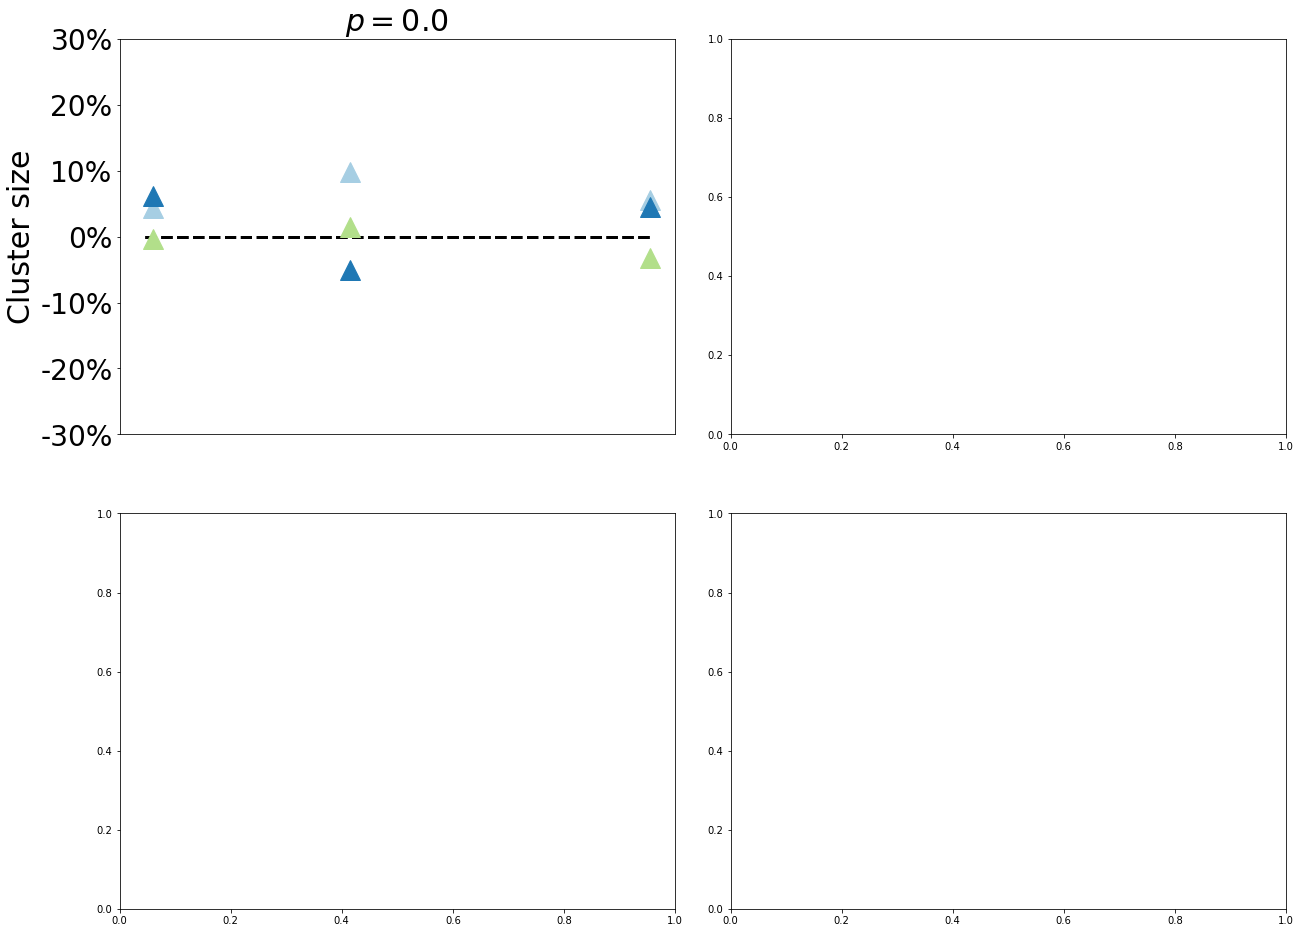

In [248]:
fig, ax = plt.subplots(2, 2, figsize = (24, 16), gridspec_kw={'wspace':0.1, 'right': 0.8})

i = 0
for p in ps:
    for R0s, color in zip(R0ss, colors_R):
        ax[int(i/2), int(i%2)].set_title('$p =$%.1f'%p, fontsize = 30)
        #ax[int(i/2), int(i%2)].plot(sample_sizes,stats_uniform[np.where((stats_uniform[:,0]==p) & (stats_uniform[:,1]==R0s))][:,4], color = color,linestyle = '--',  label = '$R_0^*=$%.3f'%R0s, linewidth = 4)
        ax[int(i/2), int(i%2)].hlines(0, N*0.018, N*0.05, linestyle = 'dashed', linewidth = 3)
        stats_aposteriori_i = stats_aposteriori[np.where((stats_aposteriori[:,0]==p) & (stats_aposteriori[:,1]==R0s))][:,4]
        stats_uniform_i = stats_uniform[np.where((stats_uniform[:,0]==p) & (stats_uniform[:,1]==R0s))][:,4]
        ax[int(i/2), int(i%2)].plot(sample_sizes, (stats_uniform_i-stats_aposteriori_i)/stats_uniform_i, '^', ms = 20, color = color, linewidth = 4, label = '$R_0^*=$%.2f'%R0s)
        if(int(i%2)==0):
            ax[int(i/2), int(i%2)].set_ylabel('Cluster size', fontsize = 30)
        if(int(i%2)==1):
            ax[int(i/2), int(i%2)].legend(fontsize = 28, bbox_to_anchor=(1,0.75))
            ax[int(i/2), int(i%2)].set_yticks([])
        if(int(i/2)==0):
            ax[int(i/2), int(i%2)].set_xticks([])
            ax[int(i/2), int(i%2)].set_ylim(-0.30,0.30)
        if(int(i/2)==1):
            ax[int(i/2), int(i%2)].set_xticks(sample_sizes)
            ax[int(i/2), int(i%2)].set_ylim(-0.30,0.30)
            
        ax[int(i/2), int(i%2)].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=N))
        ax[int(i/2), int(i%2)].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
        ax[int(i/2), int(i%2)].tick_params(labelsize = 28)
        
    i+=1
fig.savefig('../Figures/Sampling/Networks/barabasi-albert/cluster_size_detection_N%d.png'%N)



In [5]:
from platform import python_version

print(python_version())

print(np.version.version)

3.7.7
1.18.1


## Extinct Nodes

[0.21666667 0.33333333 0.58333333]


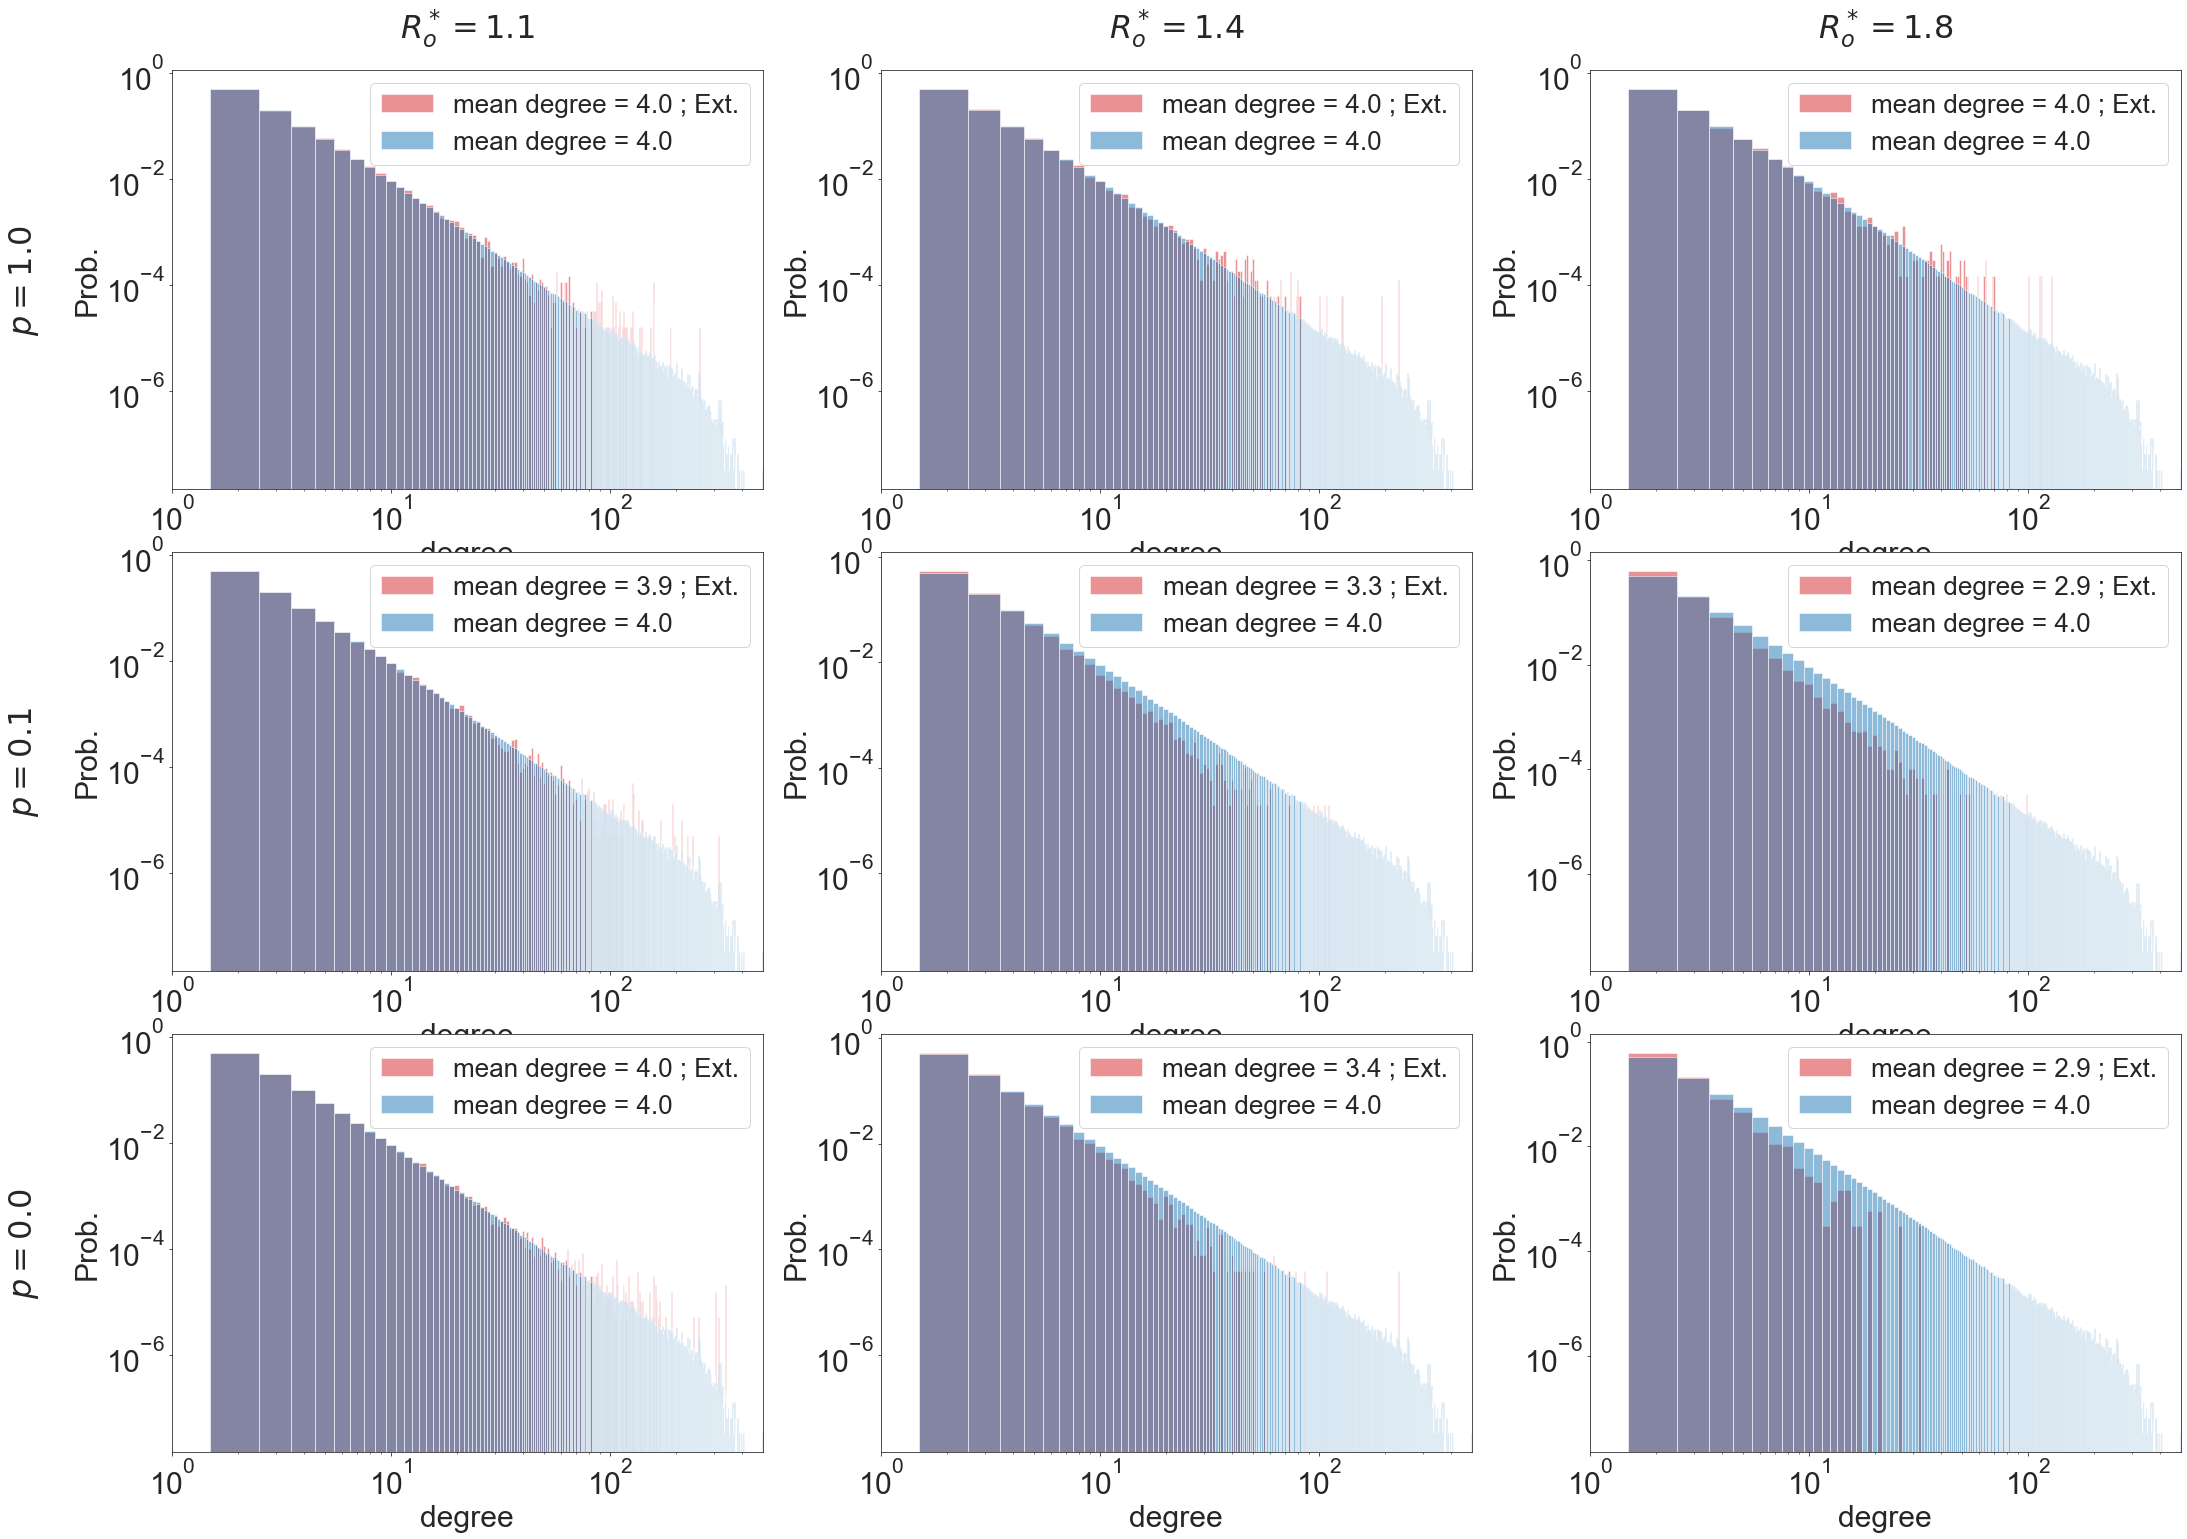

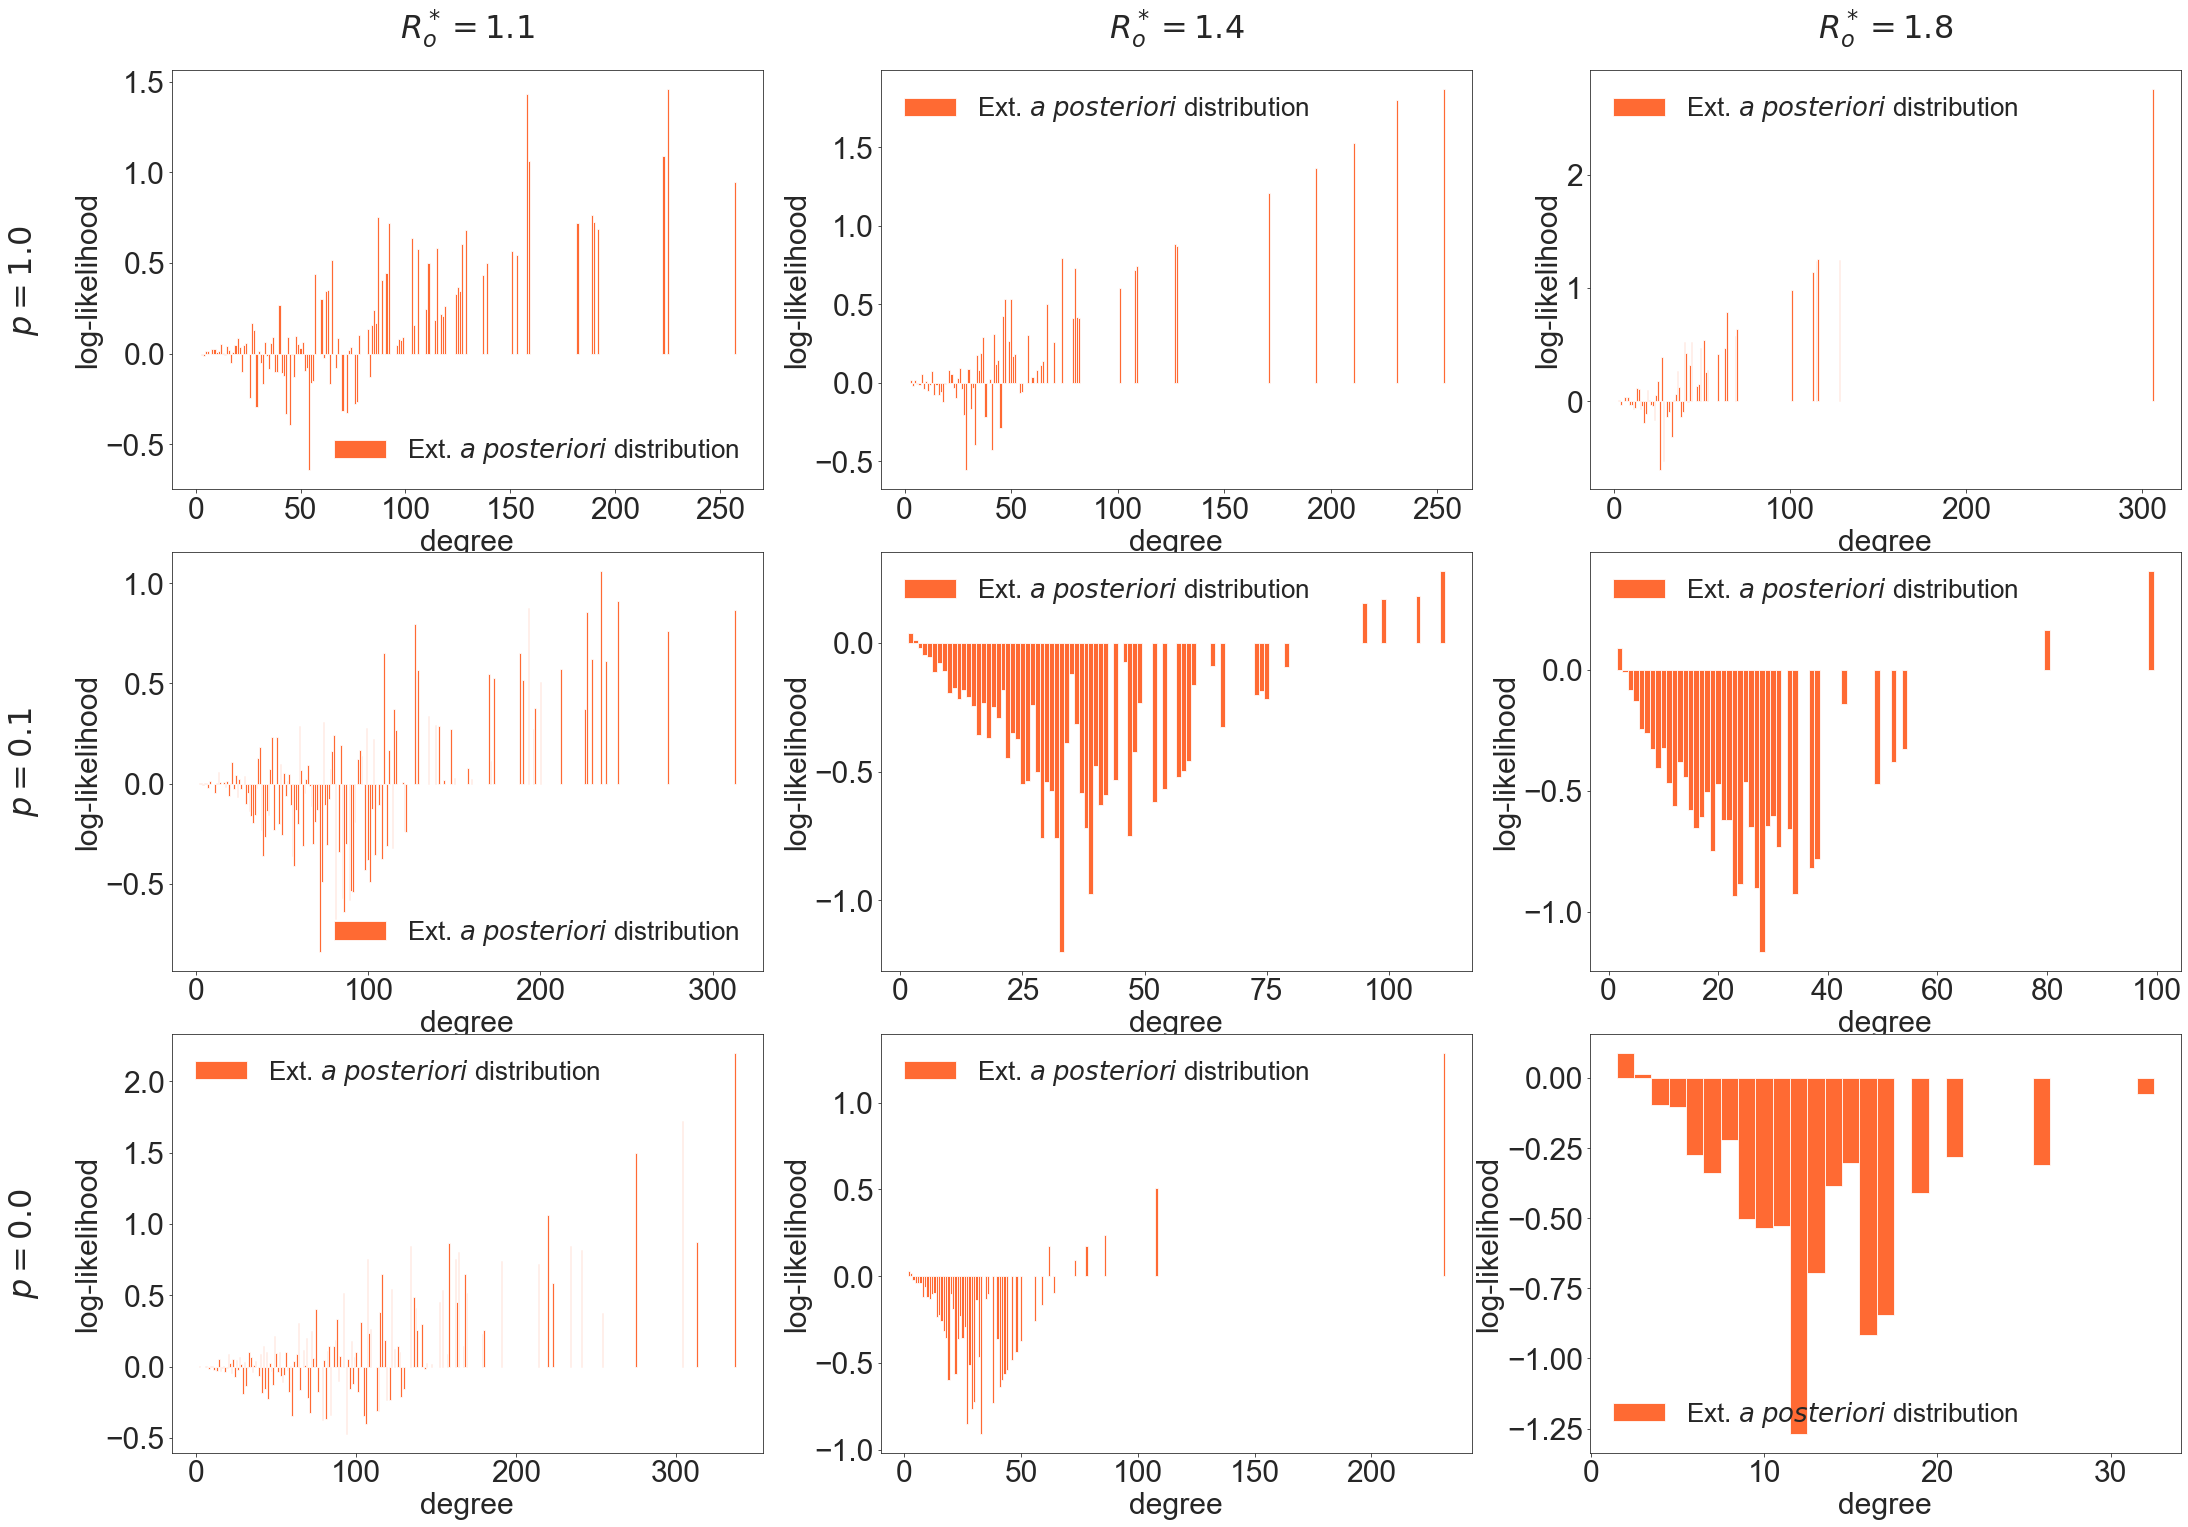

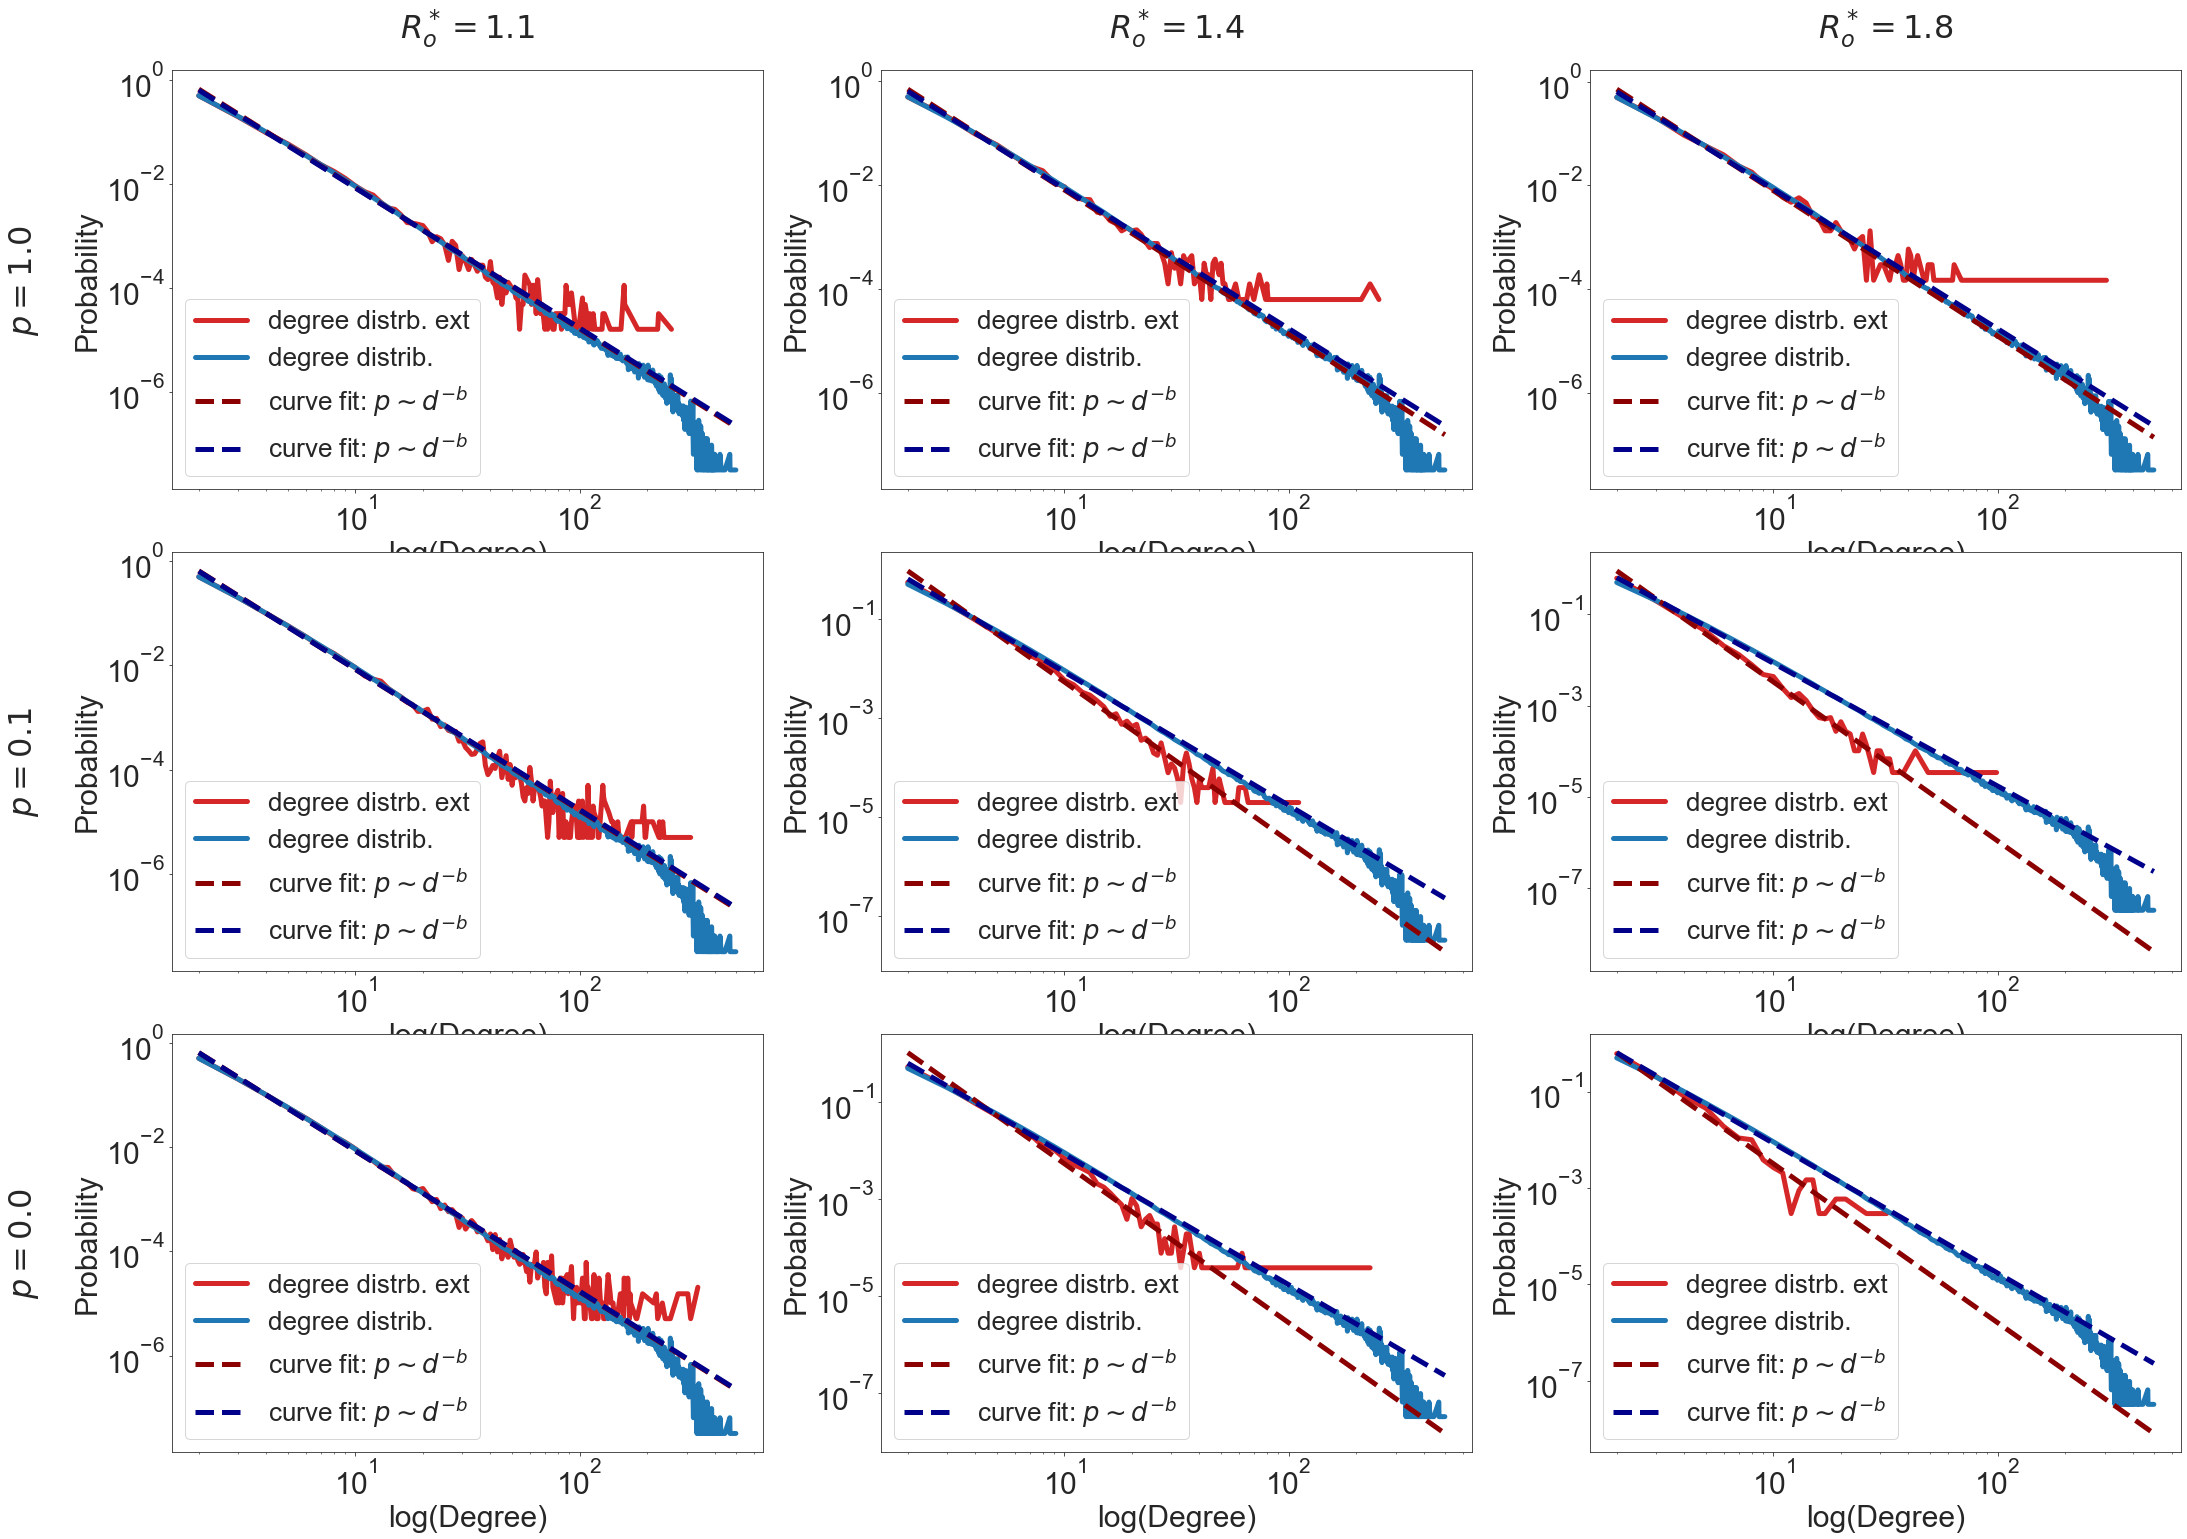

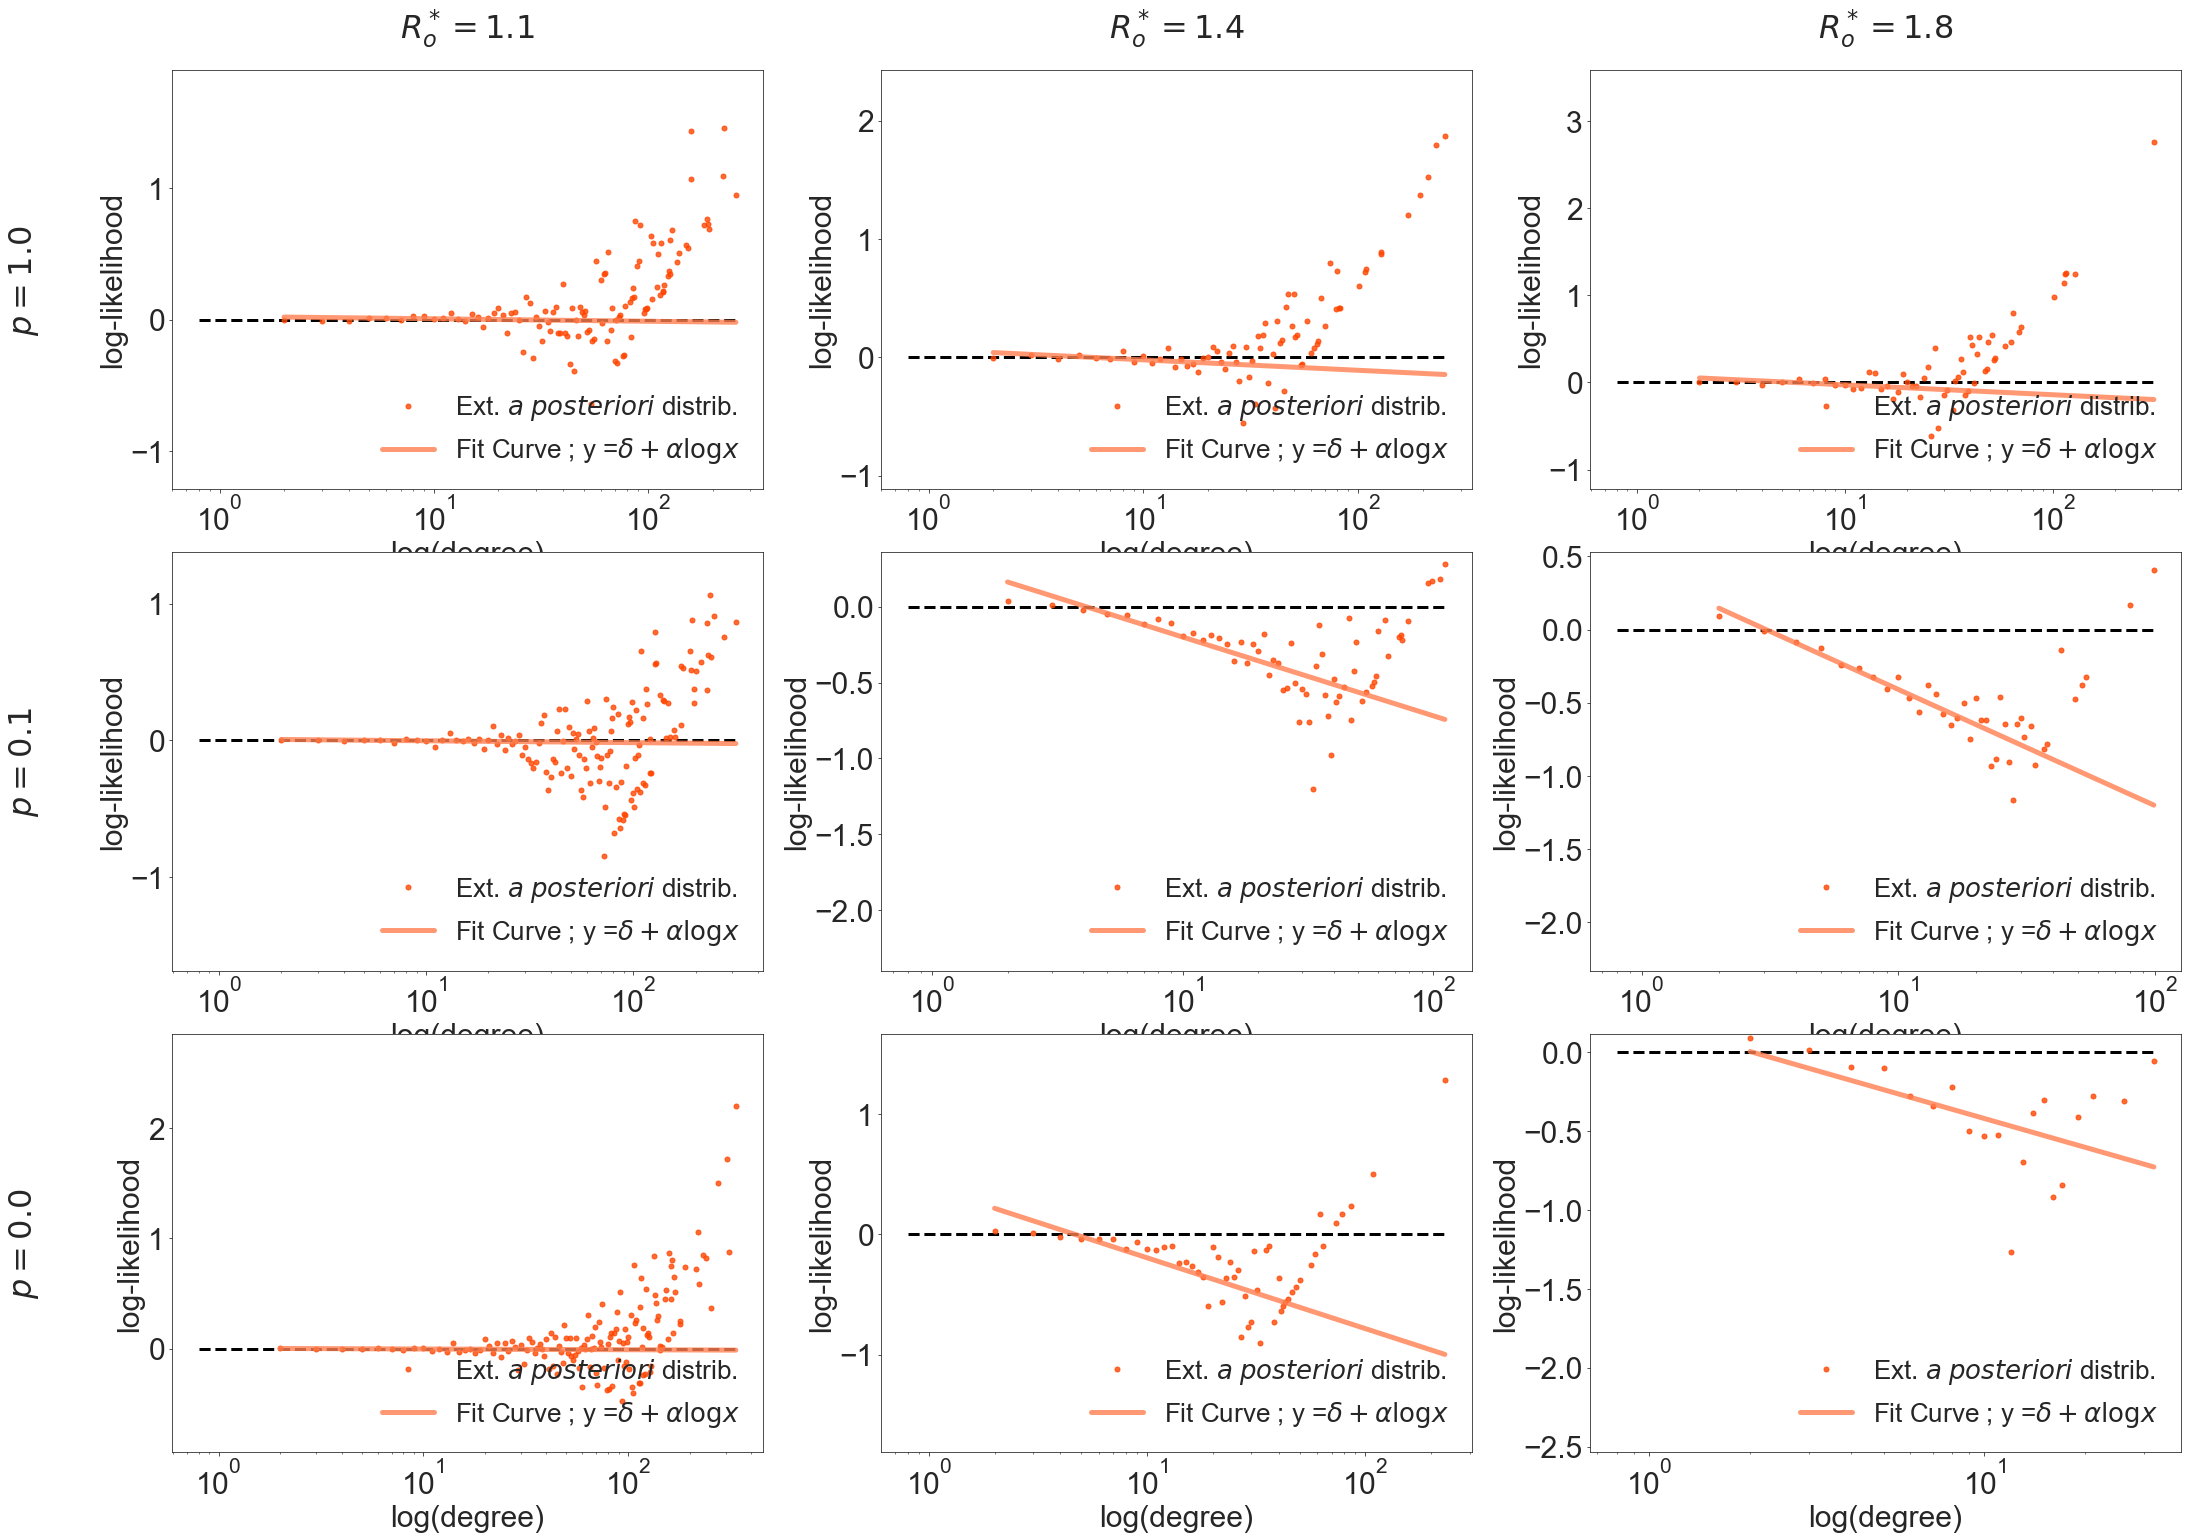

In [72]:
ps = np.array([1.0, 0.0])
degrees = np.array(range(2, max(nodeDegrees)))
graphs_names = np.array(['barabasi-albert','watts-strogatz'])

betas_temp = np.array([1.3, 3.5])*1/6
R0ss_temp = np.sqrt(1-4*((sigma*(gamma-betas_temp))/(sigma+gamma)**2)) 
print(R0ss_temp)

fig1, ax1 = plt.subplots(len(ps), len(betas_temp), figsize =(12*len(betas_temp), 8*len(ps)), gridspec_kw={'top':0.95, 'bottom': 0.15, 'hspace':0.15})
fig2, ax2 = plt.subplots(len(ps), len(betas_temp), figsize =(12*len(betas_temp), 8*len(ps)), gridspec_kw={'top':0.95, 'bottom': 0.15, 'hspace':0.15})
fig3, ax3 = plt.subplots(len(ps), len(betas_temp), figsize =(12*len(betas_temp), 8*len(ps)), gridspec_kw={'top':0.95, 'bottom': 0.15, 'hspace':0.15})
fig4, ax4 = plt.subplots(len(ps), len(betas_temp), figsize =(12*len(betas_temp), 8*len(ps)), gridspec_kw={'top':0.95, 'bottom': 0.15, 'hspace':0.15})

data = np.histogram(nodeDegrees, bins=range(2, max(nodeDegrees)+1),density = True)   

i_p = 0
for p in ps:
    i_b = 0
    ##Run over graphs
    for G, G_name in zip(graphs, graphs_names):
        ##Run over R0s
        for beta in betas_temp:
            
            if(i_b == 0):
                ax1[i_p, i_b].text(-0.25, 0.5, r'$p=%.1f$'%p, rotation=90, size = 32, horizontalalignment='center', verticalalignment='center', transform=ax1[i_p, i_b].transAxes)
                ax2[i_p, i_b].text(-0.25, 0.5, r'$p=%.1f$'%p, rotation=90, size = 32, horizontalalignment='center', verticalalignment='center', transform=ax2[i_p, i_b].transAxes)
                ax3[i_p, i_b].text(-0.25, 0.5, r'$p=%.1f$'%p, rotation=90, size = 32, horizontalalignment='center', verticalalignment='center', transform=ax3[i_p, i_b].transAxes)
                ax4[i_p, i_b].text(-0.25, 0.5, r'$p=%.1f$'%p, rotation=90, size = 32, horizontalalignment='center', verticalalignment='center', transform=ax4[i_p, i_b].transAxes)
            if(i_p == 0):
                ax1[i_p, i_b].text(0.5, 1.1, r'$R_o^*=%.1f$'%R0ss_temp[i_b], size = 32, horizontalalignment='center', verticalalignment='center', transform=ax1[i_p, i_b].transAxes)
                ax2[i_p, i_b].text(0.5, 1.1, r'$R_o^*=%.1f$'%R0ss_temp[i_b], size = 32, horizontalalignment='center', verticalalignment='center', transform=ax2[i_p, i_b].transAxes)
                ax3[i_p, i_b].text(0.5, 1.1, r'$R_o^*=%.1f$'%R0ss_temp[i_b], size = 32, horizontalalignment='center', verticalalignment='center', transform=ax3[i_p, i_b].transAxes)
                ax4[i_p, i_b].text(0.5, 1.1, r'$R_o^*=%.1f$'%R0ss_temp[i_b], size = 32, horizontalalignment='center', verticalalignment='center', transform=ax4[i_p, i_b].transAxes)

            ext_nodes1 = np.loadtxt('../Text_files/Control/Stochastic/Networks/barabasi-albert/uniform/stat_ext_R0%.1f_sigma%.1f_N%.0f_p%.1f_'%(beta/gamma,sigma, N, p)+G_name+'.txt', dtype = 'i')
            ext_nodes2 = np.loadtxt('../Text_files/Control/Stochastic/Networks/barabasi-albert/aposteriori/stat_ext_R0%.1f_sigma%.1f_N%.0f_p%.1f_'%(beta/gamma,sigma, N, p)+G_name+'.txt', dtype = 'i')
            ######### Plot histograms #########
            #plt.title(G_name + ' Network', fontsize = 16)
            data_ext = ax1[i_p, i_b].hist(np.concatenate((ext_nodes1, ext_nodes2)), bins=range(2, max(nodeDegrees)+1), align = 'left', alpha=0.5, color='tab:red', label=('mean degree = %.1f ; Ext.' % np.mean(np.concatenate((ext_nodes1, ext_nodes2)))), density = True)            
            ax1[i_p, i_b].bar(x = data[1][:-1], height=data[0],align = 'center',width = 1, alpha=0.5, color='tab:blue', label=('mean degree = %.1f' % meanDegree))
            ax1[i_p, i_b].set_xlim(1, max(nodeDegrees))
            ax1[i_p, i_b].set_xlabel('degree', fontsize = 30)
            ax1[i_p, i_b].set_ylabel('Prob.', fontsize = 30)
            #ax1[i_b, i_p].set_xticks()
            #ax1[i_b, i_p].set_yticks()
            ax1[i_p, i_b].tick_params('both', labelsize=30)
            ax1[i_p, i_b].set_yscale('log') #Comment to normal scale
            ax1[i_p, i_b].set_xscale('log') #Comment to normal scale
            ax1[i_p, i_b].legend(loc='upper right', fontsize = 26)
            ######### Calculate log_likehood from data #########
            Log_Likelihood_data = np.log10(data_ext[0]/data[0])[~np.isnan(np.log10(data_ext[0]/data[0]))]
            degrees_data = degrees[~np.isnan(np.log10(data_ext[0]/data[0]))]
            degrees_data = degrees_data[~np.isinf(Log_Likelihood_data)]
            Log_Likelihood_data = Log_Likelihood_data[~np.isinf(Log_Likelihood_data)]
            ######### Plot log_likelihood histograms #########
            ax2[i_p, i_b].bar(x=degrees_data, height =Log_Likelihood_data, align = 'center',width=1, color ='orangered', alpha = 0.8, label = r'Ext. $\it{a}$ $\it{posteriori}$ distribution')
            #ax.set_xlim(1,60)
            #ax.set_ylim(min(A)*1.2,max(A)*1.2)
            ax2[i_p, i_b].set_xlabel(r'degree', fontsize = 30)
            ax2[i_p, i_b].set_ylabel(r'log-likelihood', fontsize = 30)
            ax2[i_p, i_b].tick_params('both', labelsize=30)
            #ax2[i_b, i_p].set_xscale('log')
            ax2[i_p, i_b].legend(fontsize = 26, frameon=False)
            ######### Fit each histogram #########
            A = data_ext[0][0:][data_ext[0][0:]!=0]
            degreesA = degrees[data_ext[0][0:]!=0]
            poptA, pcovA = curve_fit(my_linear_function, np.log10(degreesA[degreesA<=30]), np.log10(A[degreesA<=30]))
            B = data[0][0:][data[0][0:]!=0]
            degreesB = degrees[data[0][0:]!=0]
            poptB, pcovB = curve_fit(my_linear_function, np.log10(degreesB[degreesB<=30]), np.log10(B[degreesB<=30]))
            Log_Likelihood = (my_linear_function(np.log10(degrees), *poptA)-my_linear_function(np.log10(degrees), *poptB))
            ######### Plot fits of both histograms #########
            ax3[i_p, i_b].plot(degreesA, A, linewidth = 5, color = 'tab:red', label = 'degree distrb. ext')
            ax3[i_p, i_b].plot(degreesB, B, linewidth = 5, color = 'tab:blue', label = 'degree distrib.')
            ax3[i_p, i_b].plot(degrees, 10**(my_linear_function(np.log10(degrees), *poptA)), '--', linewidth = 5, color = 'darkred', label = r'curve fit: $p\sim d^{-b}$')
            ax3[i_p, i_b].plot(degrees, 10**(my_linear_function(np.log10(degrees), *poptB)), '--', linewidth = 5, color = 'darkblue', label = r'curve fit: $p\sim d^{-b}$')
            ax3[i_p, i_b].set_yscale('log')
            ax3[i_p, i_b].set_xscale('log')
            ax3[i_p, i_b].set_xlabel('log(Degree)', fontsize = 30)
            ax3[i_p, i_b].set_ylabel('Probability', fontsize = 30)
            ax3[i_p, i_b].tick_params(labelsize = 30)
            ax3[i_p, i_b].legend(fontsize = 26)
            ######### Fit each log_likelihood and save the parameters #########
            if(p == 0.0):
                popt, pcov = curve_fit(my_linear_function, np.log10(degrees), Log_Likelihood)
            if(p == 0.1):
                popt, pcov = curve_fit(my_linear_function, np.log10(degrees), Log_Likelihood) 
            if(p == 1.0):
                popt, pcov = curve_fit(my_linear_function, np.log10(degrees), Log_Likelihood)
            ######### Plot fits of log_likelihood together with data #########           
            degrees_array = np.linspace(min(degrees), max(degrees_data), 200)
            ax4[i_p, i_b].plot(degrees_data, Log_Likelihood_data,'.',  color ='orangered', alpha = 0.8, ms = 10, label = r'Ext. $\it{a}$ $\it{posteriori}$ distrib.')
            ax4[i_p, i_b].plot(degrees_array, my_linear_function(np.log10(degrees_array), *popt),'-', color ='coral', linewidth = 5, alpha = 0.8, label = r'Fit Curve ; y =$ \delta + \alpha\log{x}$')
            ax4[i_p, i_b].hlines(0, 0.8, max(degrees_data), linestyle = 'dashed', linewidth = 3)
            ax4[i_p, i_b].set_ylim(abs(min(Log_Likelihood_data))*-2,max(Log_Likelihood_data)*1.3)
            ax4[i_p, i_b].set_xscale('log')
            ax4[i_p, i_b].set_xlabel(r'log(degree)', fontsize = 30)
            ax4[i_p, i_b].set_ylabel(r'log-likelihood', fontsize = 30)
            ax4[i_p, i_b].tick_params('both', labelsize=30)
            if(p != 1.0):
                ax4[i_p, i_b].legend(fontsize = 26, frameon=False, loc = 4)
            if(p == 1.0):
                ax4[i_p, i_b].legend(fontsize = 26, frameon=False, loc = 4)
                
            i_b+=1
        i_p+=1
        
fig1.savefig('../Figures/Control/Stochastic/Sampling/Networks/'+G_name+'/hist_degree_ext_N%.0f_'%(N)+G_name+'.pdf', transparent = True)
fig2.savefig('../Figures/Control/Stochastic/Sampling/Networks/'+G_name+'/hist_likelihood_ext_N%.0f_'%(N)+G_name+'.pdf', transparent = True)
fig3.savefig('../Figures/Control/Stochastic/Sampling/Networks/'+G_name+'/fits_hist_degree_ext_N%.0f_'%(N)+G_name+'.pdf', transparent = True)
fig4.savefig('../Figures/Control/Stochastic/Sampling/Networks/'+G_name+'/fits_likelihood_ext_N%.0f_'%(N)+G_name+'.pdf', transparent = True)

# Sampling Statistics

In [8]:
model1 = SEIRSNetworkModel(G=G,beta=1/2,sigma=sigma, gamma =gamma, p = 1, initE = 0, initI = 1, store_Xseries=True)
model1.run(T=20*1.1, print_interval = False);

In [9]:
np.shape(model1.degree)

(8000, 1)

In [10]:
a = model1.degree.reshape(1,8000)[0]
a

array([ 11., 297., 106., ...,   2.,   2.,   2.])

In [11]:
b = np.array([max(1,(-1.3 + 1.9*np.log10(a[i]))) for i in range(len(a))])
b = b/np.sum(b)
b

array([0.00012382, 0.00042076, 0.0003155 , ..., 0.00012382, 0.00012382,
       0.00012382])

In [12]:
sample = np.random.choice(a = np.array(range(N)), size = 100, replace = False, p = b)

In [13]:
sample

array([2735, 6364,  997, 3888, 7128, 1101, 2473, 1997, 5413, 2283,  628,
       5014,  643, 7928, 1106, 3503, 1115, 7446, 2278, 1972, 6120,   84,
       3864, 5147, 1336, 6568, 1521, 6296, 3528, 6492, 7911, 7896, 1549,
       1170,  192, 2041, 7870, 1216, 6040, 3237, 3283,  966, 2100, 2205,
       5364, 2417, 7462, 1468, 2037, 2215,  784,  190,  251,  642, 6306,
       1304, 6403, 7778, 7926, 3448, 4494, 4301, 1987, 3831, 6280, 5391,
       3761, 3071, 3482, 7295,  991, 6104, 4925, 7747, 5966, 1380, 2129,
       7643, 4588, 1221,  650, 7511, 3148, 5929, 7253,  341, 2314,   53,
       1254,   38, 1200,  166, 5931,  741, 4312, 1655,  226,  765, 5518,
        644])

In [13]:
nodeDegrees = np.loadtxt('../Text_files/Control/Stochastic/Networks/barabasi-albert/network_degree_distrib.txt', dtype=np.int32)
print(nodeDegrees)

[ 17  36 237 ...   2   2   2]


In [19]:
nodes = np.array([1,4,5,7,9])
degreesss = np.array([11,2,3,4,2,60,7,1,20,3])
p = degreesss[nodes]

In [21]:
np.array([max(1,(-1.3 + 1.9*np.log10(degreesss[i]))) for i in nodes])

array([1.        , 1.        , 2.07848738, 1.        , 1.        ])

In [18]:
I_data = np.loadtxt('../Text_files/Control/Stochastic/Networks/barabasi-albert/aposteriori/ensemble_I_R0%.1f_sigma%.1f_N8000_p%.1f_barabasi-albert.txt'%(beta/gamma,sigma,p))

np.mean([I_data[i,:] for i in range(len(I_data[:,0])) if I_data[i,-1]!=0],axis=0)

array([1.        , 1.11392405, 1.37974684, 1.75105485, 2.00843882,
       2.2742616 , 2.45991561, 2.72995781, 3.00843882, 3.39240506,
       3.57805907, 3.97046414, 4.29535865, 4.69198312, 5.01687764,
       5.42616034, 5.89451477, 6.20253165, 6.60337553, 7.13924051,
       7.5021097 , 8.02109705, 8.55696203, 9.17721519, 9.5021097 ])

In [173]:
M = np.array(range(10))

In [176]:
M[M<5]

array([0, 1, 2, 3, 4])

In [47]:
plt.cm.Paired(range(6))

array([[0.65098039, 0.80784314, 0.89019608, 1.        ],
       [0.12156863, 0.47058824, 0.70588235, 1.        ],
       [0.69803922, 0.8745098 , 0.54117647, 1.        ],
       [0.2       , 0.62745098, 0.17254902, 1.        ],
       [0.98431373, 0.60392157, 0.6       , 1.        ],
       [0.89019608, 0.10196078, 0.10980392, 1.        ]])

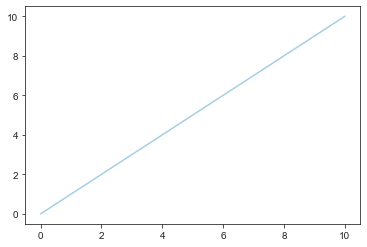

In [45]:
plt.plot(np.linspace(0,10,100),np.linspace(0,10,100), color=plt.cm.Paired((0,1,3))[0])

In [ ]:

colors2 = ['darkgreen', 'darkblue', 'darkred']
colors = ['green', 'blue', 'red']
fig, ax = plt.subplots(len(ps), len(betas), figsize =(12*len(betas), 8*len(ps)), gridspec_kw={'top':0.93, 'bottom': 0.12, 'hspace':0.35})
i_p = 0
file = open('../Text_files/Sampling/Networks/barabasi-albert/uniform/uniform_sampling.txt', 'w')
for p in ps:
    i_b = 0
    for beta, T_total in zip(betas, Ts_total):
        days = np.array(range(T_total+1))
        I_data = np.loadtxt('../Text_files/Stochastic/Networks/barabasi-albert/ensemble_I_R0%.1f_sigma%.1f_N8000_p%.1f_barabasi-albert.txt'%(beta/gamma,sigma,p))
        #I_data_ap = np.loadtxt('../Text_files/Control/Stochastic/Networks/barabasi-albert/aposteriori/ensemble_I_R0%.1f_sigma%.1f_N8000_p%.1f_barabasi-albert.txt'%(beta/gamma,sigma,p))
        I_avg = np.mean(I_data , axis = 0)
        I_data2 = [I_data[i,:] for i in range(len(I_data[:,0])) if I_data[i,-1]!=0]
        I_avg_not_ext = np.mean(I_data2 , axis = 0)
        I_det = np.loadtxt('../Text_files/Deterministic/deterministic_R0%.1f_sigma%.1f.txt'%(beta/gamma,sigma))
        for m, color, color2 in zip(sample_sizes, colors, colors2):
            data_prob = np.loadtxt('../Text_files/Sampling/Networks/barabasi-albert/prob_cum_detection_time_R0%.1f_sigma%.1f_N%d_p%.1f_m%d_barabasi-albert.txt'%(beta/gamma,sigma,N,p,m))
            ax[i_p, i_b].plot(days, np.cumsum(data_prob[0,:]), color = color2, linewidth = 4, label = 'm=%d'%m)
            #ax.plot(days,np.cumsum(data_prob[1,:]), color = 'k', linewidth = 4, label = 'm=%d, deterministic'%m)
            ax[i_p, i_b].hlines(1,0,I_det[0,:][-1], linestyle = 'dashed', linewidth = 3)
            ax[i_p, i_b].hlines(.9,0,I_det[0,:][-1], linestyle = 'dashed', linewidth = 3)
            
            data_sampling = np.loadtxt('../Text_files/Sampling/Networks/barabasi-albert/uniform/sampling_stats_R0%.1f_sigma%.1f_N8000_p%.1f_m%d_barabasi-albert.txt'%(beta/gamma,sigma,p,m))
            #time_detec_aposteriori = np.loadtxt('../Text_files/Sampling/Networks/barabasi-albert/aposteriori/detect_time_R0%.1f_sigma%.1f_N8000_p%.1f_m%d_barabasi-albert.txt'%(beta/gamma,sigma,p,m))
            #n_detec_aposteriori = np.loadtxt('../Text_files/Sampling/Networks/barabasi-albert/aposteriori/detect_R0%.1f_sigma%.1f_N8000_p%.1f_m%d_barabasi-albert.txt'%(beta/gamma,sigma,p,m))
            
            #j=0
            #time_detec_succ = np.array([])
            #for i in range(len(I_data[:,0])):
            #    if(n_detec[i]!=0):
            #        if(I_data[i,-1]!=0):
            #            time_detec_succ = np.append(time_detec_succ, time_detec[j])
            #        j+=1 
            #j=0
            #time_detec_succ_aposteriori = np.array([])
            #for i in range(len(I_data_ap[:,0])):
            #    if(n_detec_aposteriori[i]!=0):
            #        if(I_data_ap[i,-1]!=0):
            #            time_detec_succ_aposteriori = np.append(time_detec_succ_aposteriori, time_detec_aposteriori[j])
            #        j+=1 
        
            #ax.hist(time_detec, bins = range(T_total+1), density=True, alpha = 0.8, color = color, cumulative=True, align = 'left', label = 'uniform')
            data_uniform = np.histogram(data_sampling[:,0][data_sampling[:,4]==0], bins = range(T_total+1), density=True)
            ax[i_p, i_b].plot(range(T_total), np.cumsum(data_uniform[0]),'-o', color = color, ms = 8, linewidth = 1)
            #ax.hist(time_detec_aposteriori, bins = range(T_total+1), density=True, alpha = 0.3, color = color2, cumulative=True, align = 'left', label = 'aposteriori')
            #data_aposteriori = np.histogram(time_detec_aposteriori, bins = range(T_total+1), density=True)
            #ax.plot(range(T_total), data_aposteriori[0],'-^', color = 'darkgreen', ms = 8, linewidth = 1,label = 'aposteriori')
            
            ## Plot setup
            ax[i_p, i_b].set_xlabel('Time [days]', fontsize = 30)
            ax[i_p, i_b].set_ylabel('Prob. detection', fontsize = 30)
            ax[i_p, i_b].tick_params(labelsize = 30)
            ax[i_p, i_b].set_ylim(0,1.1)
            ax[i_p, i_b].set_xticks(I_det[0,:][::int(T_total/5)])
            ax[i_p, i_b].set_xlim(0,T_total)
            ax[i_p, i_b].legend(loc = 4, fontsize = 26)
            ## Upper axis
            ax2 = ax[i_p, i_b].twiny()
            ax2.set_xticks(ax[i_p, i_b].get_xticks())
            ax2.set_xlim(ax[i_p, i_b].get_xlim())
            #print(I_det[0,:], ax.get_xticks(), I_avg_not_ext)
            ax2.set_xticklabels(I_avg_not_ext[np.isin(I_det[0,:],ax[i_p, i_b].get_xticks())].astype(int))
            ax2.set_xlabel('Individuals', fontsize = 30)
            ax2.tick_params(labelsize = 20)
            #save data
            R0s = np.sqrt(1-4*((sigma*(gamma-beta))/(sigma+gamma)**2))
            time90 = np.where(np.cumsum(data_uniform[0])<0.9)[0][-1]
            ind90 = I_avg_not_ext[time90]
            np.savetxt(file, np.array([p, R0s, m, time90, ind90]), newline = ' ')
            file.write("\n")
            #fig.savefig('../Figures/Control/Stochastic/Sampling/Networks/'+graphs_names[0]+'/Prob_R0%.1f_sigma%.1f_p%.1f_m%d.pdf'%(beta/gamma, sigma,p,m))
        i_b +=1
    i_p+=1
file.close()